# imports

In [3]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

Invoking __init__.py for NDNT.utils


In [4]:
e = exp.load('iter_exps10', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.10018215

In [5]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

In [6]:
dataset.filenames

['expt04', 'expt06', 'expt09', 'expt11']

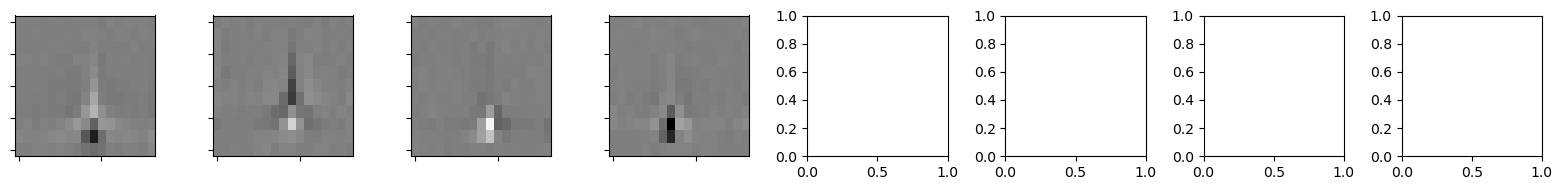

In [7]:
e.trials[0].model.NDN.plot_filters()

# readout weights

(66, 111)


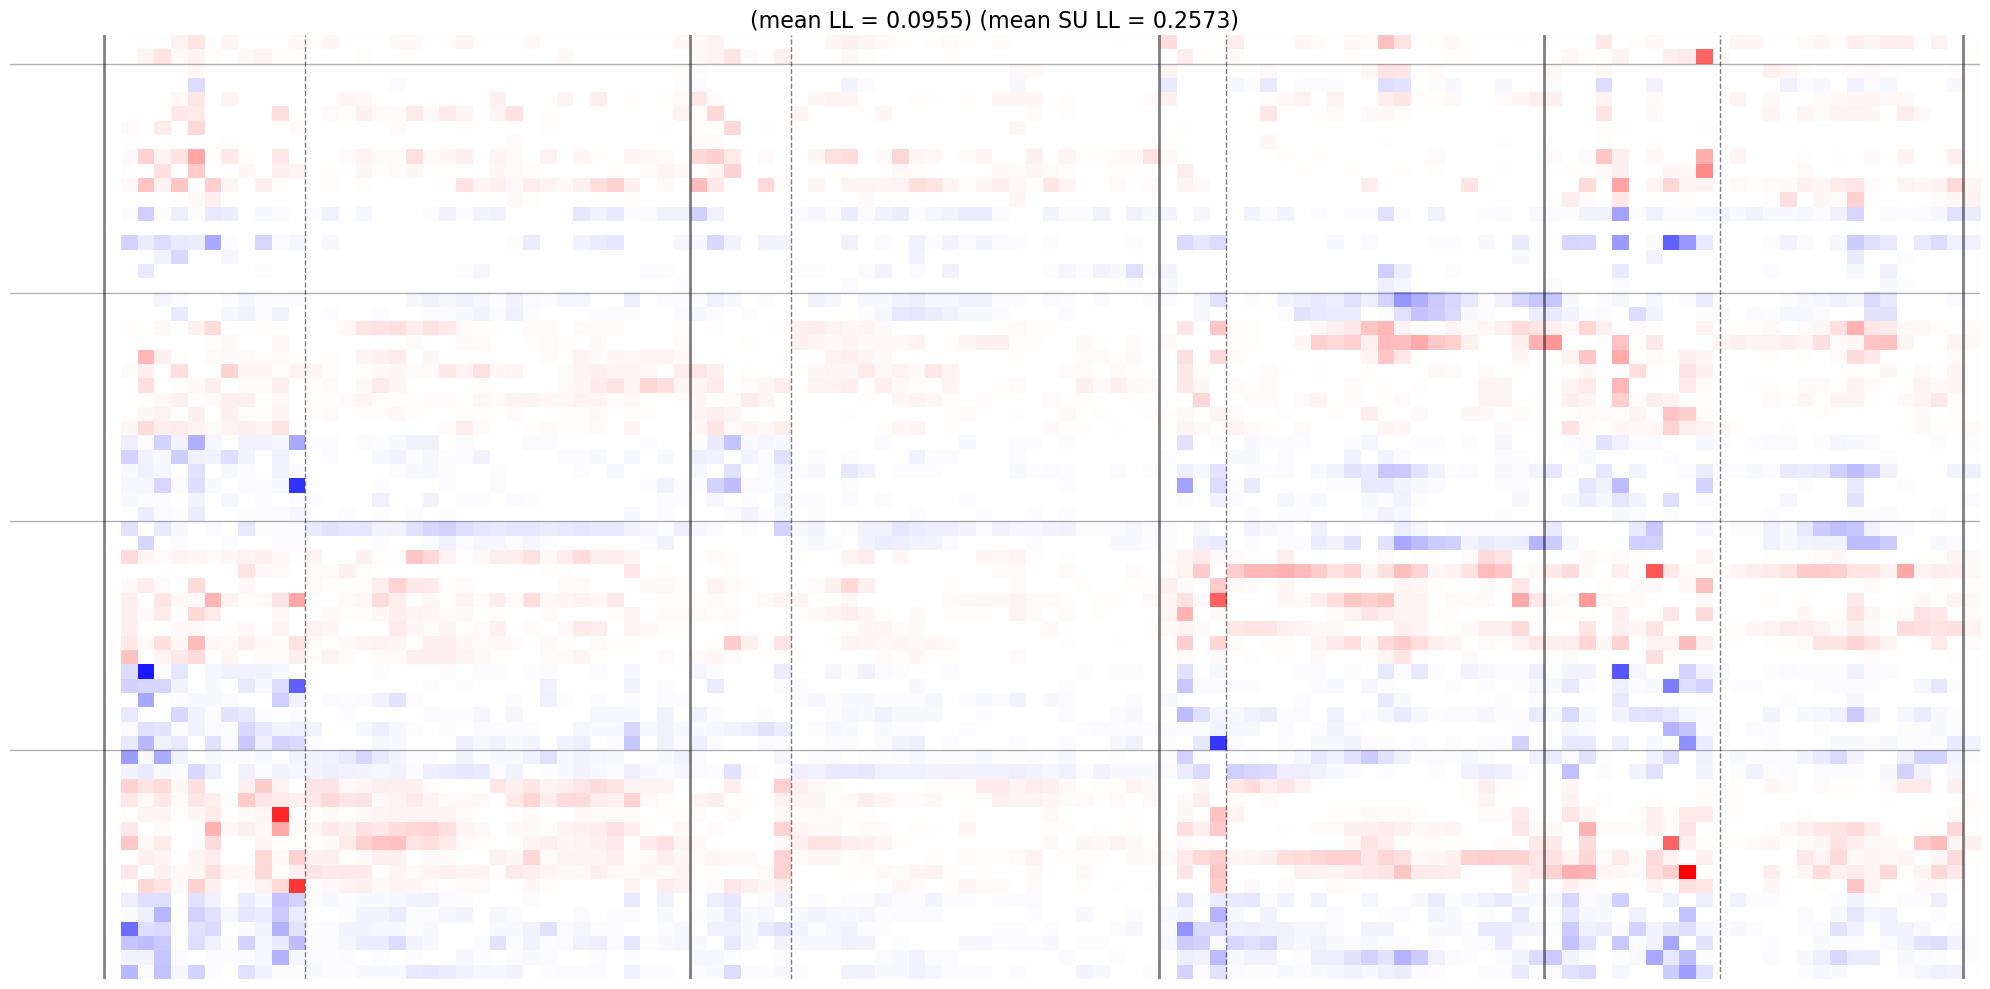

In [6]:
readout_weights = np.sum(e.trials[0].model.networks[-1].layers[-1].weights[:,:,:], axis=1)
print(readout_weights.shape)
# make inhibitory weights negative (every 12 weights need to be flipped)
readout_weights[3,:] = -readout_weights[3,:]
for i in range(12,readout_weights.shape[0],16):
    readout_weights[i:i+8,:] = -readout_weights[i:i+8,:]

# get the mean LLs for just the SUs in k
mean_SU_LLs = np.mean(e.trials[0].LLs[dataset.SUs])

# get the mean LLs for k
mean_LLs = np.mean(e.trials[0].LLs)

fig = plt.figure(figsize=(20,10))
plot.imagesc(readout_weights, cmap='bwr', colrow=False, origin='upper')
plt.title('(mean LL = %.4f)' % mean_LLs + ' (mean SU LL = %.4f)' % mean_SU_LLs, fontsize=16)
plt.axis('off')

# put a vertical line between each experiment
for expt_boundary in expt_boundaries:
    plt.axvline(expt_boundary-1-0.5, color='k', linewidth=2, alpha=0.5)

# put a vertical line between the SUs and the MUs
# get the indices of the SUs where the experiment boundaries are
SU_boundaries = np.where(np.diff(dataset.SUs) > 1)[0]

for SU_boundary in SU_boundaries:
    plt.axvline(dataset.SUs[SU_boundary]+1-0.5, color='k', linewidth=1, alpha=0.5, linestyle='--')
# plot the last SU boundary
plt.axvline(dataset.SUs[-1]+1, color='k', linewidth=1, alpha=0.5, linestyle='--')

layer_boundaries = [0, 2, 18, 34, 50, 66]

# put a horizontal line between each layer
for layer_boundary in layer_boundaries[1:-1]:
    plt.axhline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# projection weights

Projection weights shape (2, 15, 16)


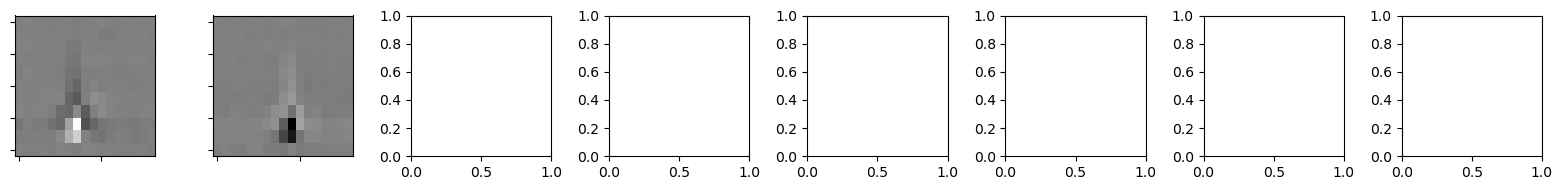

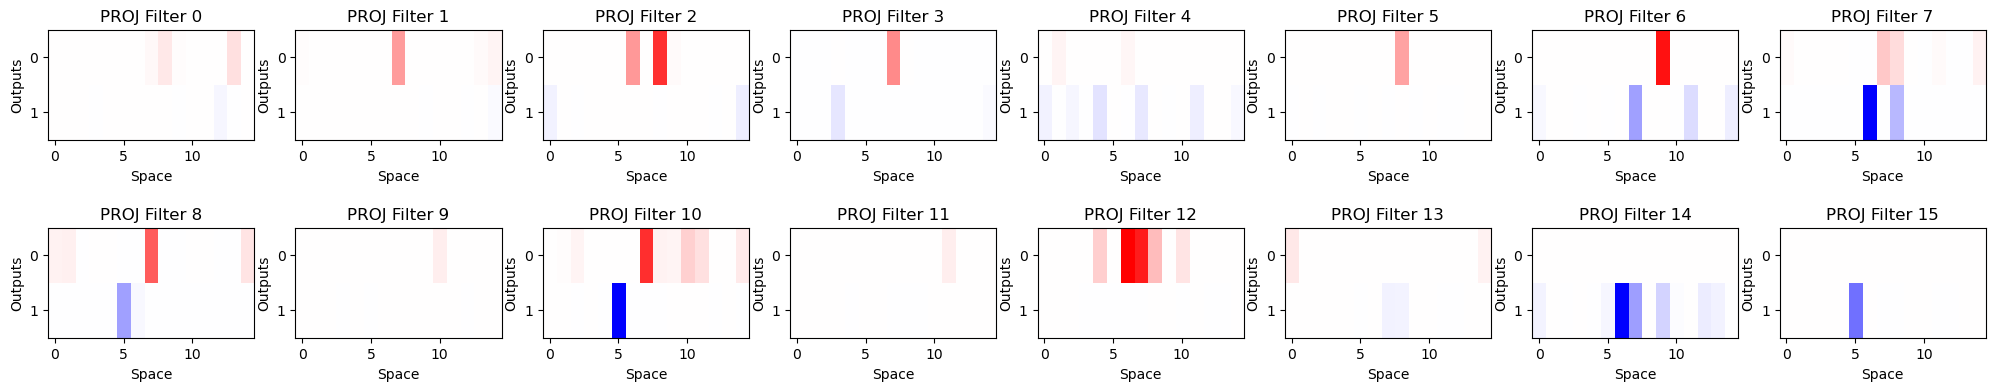

In [7]:
proj_weights = e.trials[0].model.networks[0].layers[1].weights
proj_weights[1,:,:] = -proj_weights[1,:,:]
proj_max = np.max(proj_weights)
proj_min = -proj_max

print('Projection weights shape', proj_weights.shape)

e.trials[0].model.NDN.plot_filters()

# make a 2x2 grid
fig = plt.figure(figsize=(25,4))
# put space between the plots
fig.subplots_adjust(wspace=0.2, hspace=0.8)
rows,cols = 2,8
gridspec = fig.add_gridspec(rows,cols)
for i in range(proj_weights.shape[2]):
    row,col = np.unravel_index(i, (rows,cols))
    ax = fig.add_subplot(gridspec[row,col])
    ax.imshow(proj_weights[:,:,i], cmap='bwr', aspect='auto', vmin=proj_min, vmax=proj_max)
    ax.set_title('PROJ Filter '+str(i))
    ax.set_xlabel('Space')
    ax.set_ylabel('Outputs')
plt.show()

# STAs

In [8]:
preds = predict.calc_preds(dataset, e.trials[0].model)

  7%|██████████▎                                                                                                                                     | 1/14 [00:20<04:31, 20.91s/it]

KeyboardInterrupt



In [ ]:
stas, pred = predict.calc_STAs(dataset, preds)

In [ ]:
plot.plot_STAs(stas, pred, dataset, e.trials[0])

In [27]:
dirsel_neurons = [0, 2, 63, 87] + [1, 3, 36, 89]
print(dirsel_neurons)
# get the top spikes for the direction selective neurons
top_spikes = np.argsort(dataset.robs[:,dirsel_neurons], axis=0)[-10:,:]

[0, 2, 63, 87, 1, 3, 36, 89]


In [ ]:
fig = plt.figure(figsize=(25,4))
for ni in range(len(dirsel_neurons)):
    plt.subplot(1,len(dirsel_neurons),ni+1)
    plt.hist(dataset.robs[top_spikes[:,ni], dirsel_neurons[ni]], bins=5)
    plt.title('Neuron %d' % dirsel_neurons[ni])
plt.show()
#torch.min(dataset.robs[top_spikes[:,0], dirsel_neurons[0]])

# jacobian

In [ ]:
# compare the average Jacobians for the direction selective neurons to the average Jacobians for the non-direction selective neurons

In [28]:
results = []
for ni in range(len(dirsel_neurons)):
    results.append(predict.predict(e.trials[0].model, dataset=dataset[top_spikes[:,ni]], calc_jacobian=True, verbose=False))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00it/s]


Neuron readout weights shape (68, 36)
Num layers 3
--> 0 4
Network 0 Layer 0 Jacobian shape (10, 4, 36, 4, 504) Neuron weights shape (68, 36)
Layer readout weights shape (4, 36)
Layer Jacobians shape (4, 36, 4, 504)
--> 4 20
Network 0 Layer 1 Jacobian shape (10, 16, 36, 4, 504) Neuron weights shape (68, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (16, 36, 4, 504)
--> 20 36
Network 0 Layer 2 Jacobian shape (10, 3, 16, 36, 1, 504) Neuron weights shape (68, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (3, 16, 36, 1, 504)
iters 3
Neuron readout weights shape (68, 36)
Num layers 3
--> 0 4
Network 0 Layer 0 Jacobian shape (10, 4, 36, 4, 504) Neuron weights shape (68, 36)
Layer readout weights shape (4, 36)
Layer Jacobians shape (4, 36, 4, 504)
--> 4 20
Network 0 Layer 1 Jacobian shape (10, 16, 36, 4, 504) Neuron weights shape (68, 36)
Layer readout weights shape (16, 36)
Layer Jacobians shape (16, 36, 4, 504)
--> 20 36
Network 0 Layer 2 Jacobian shape (10

/tmp/ipykernel_128356/437112374.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(subunits*2,1))


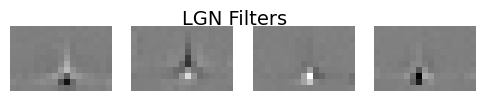

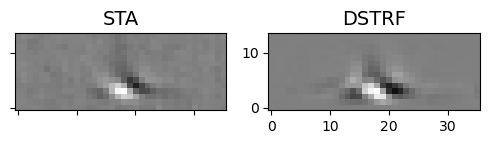

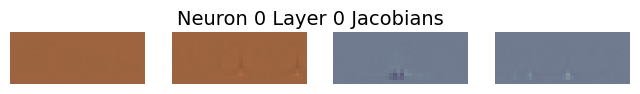

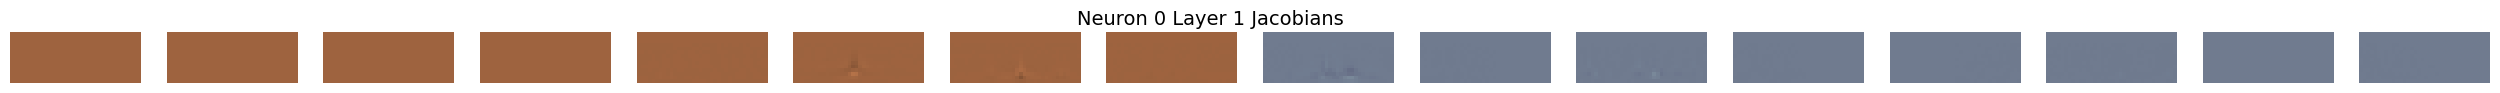

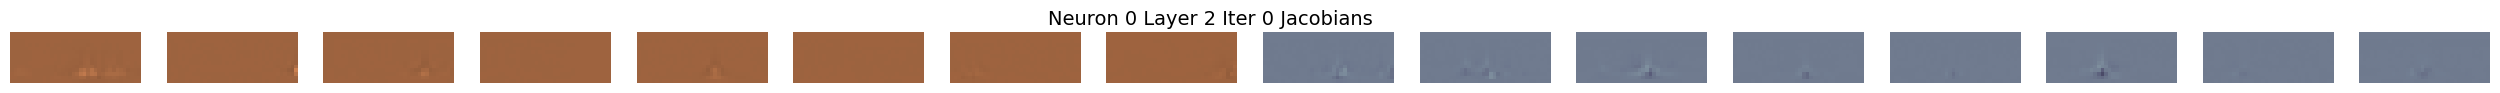

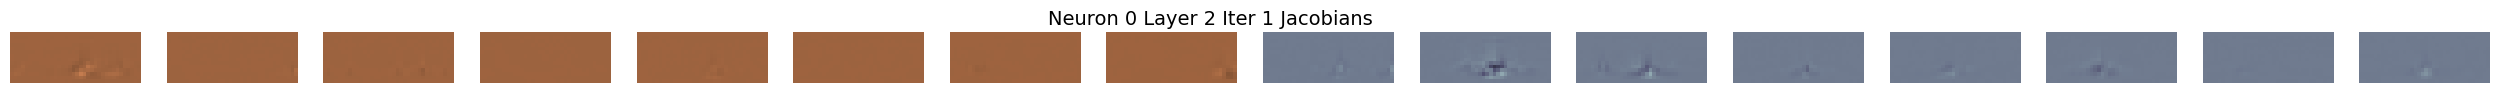

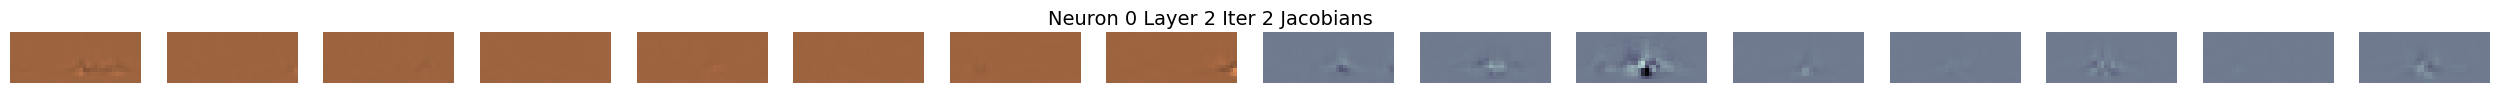

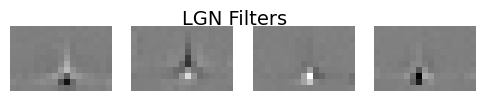

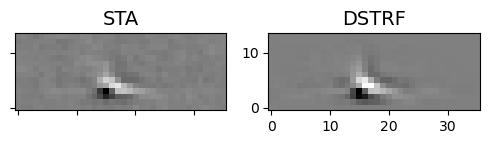

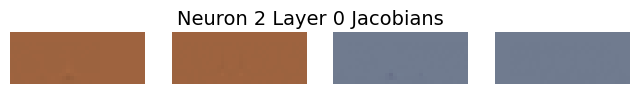

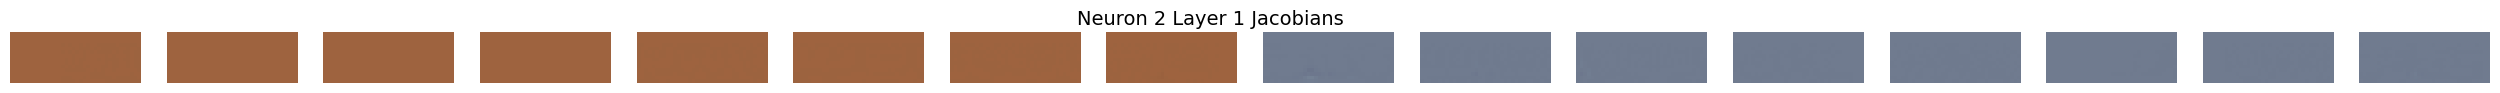

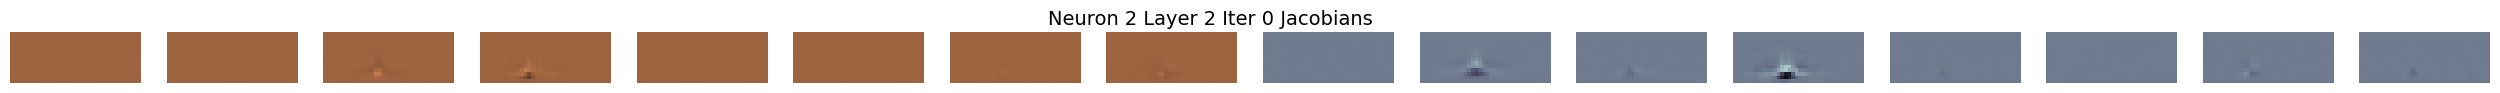

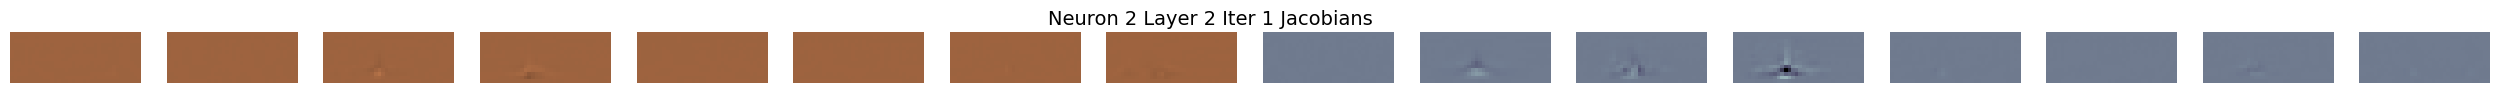

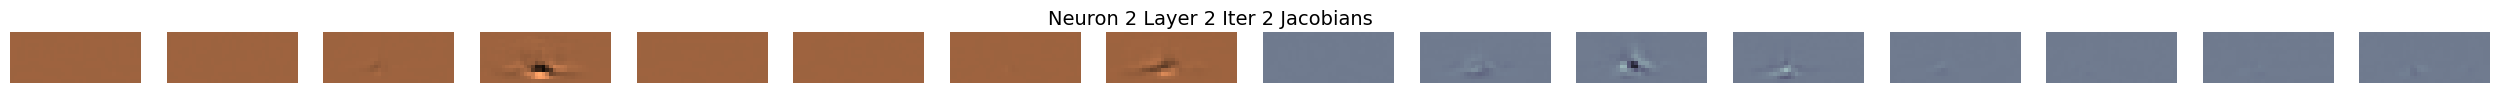

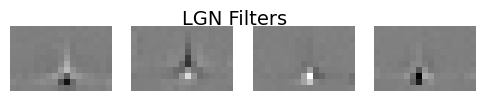

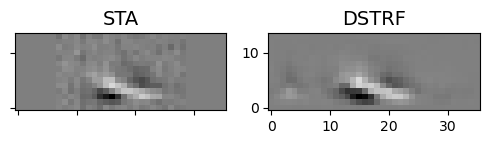

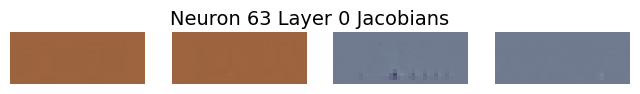

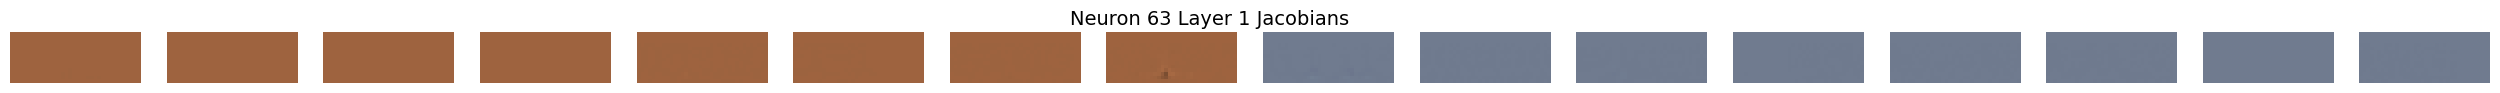

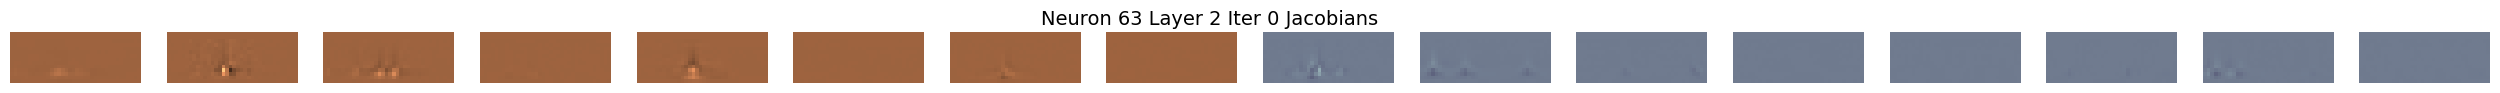

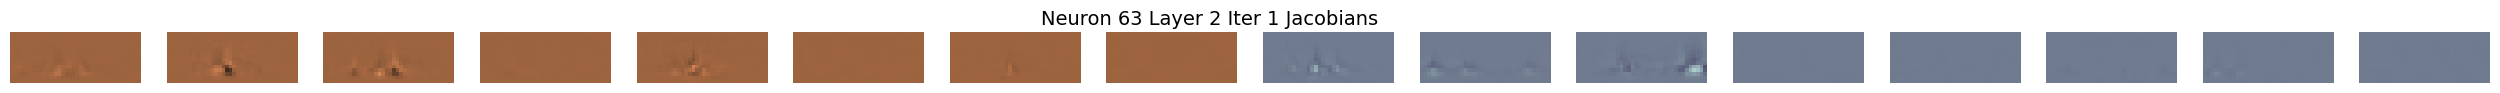

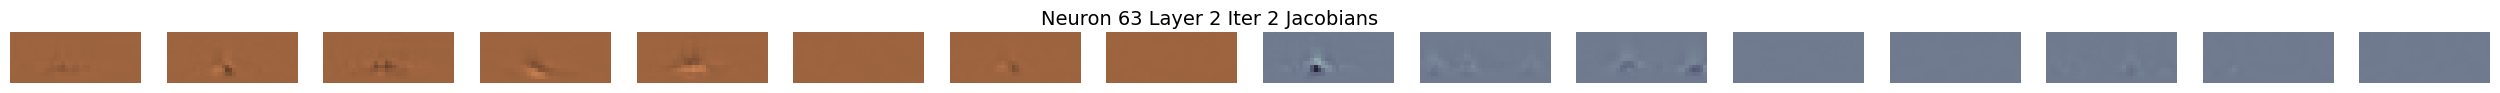

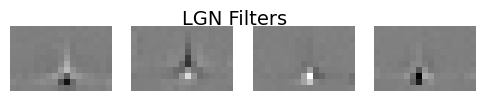

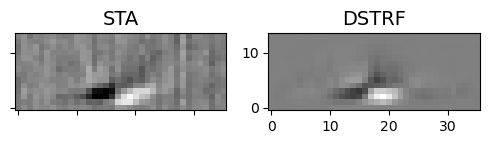

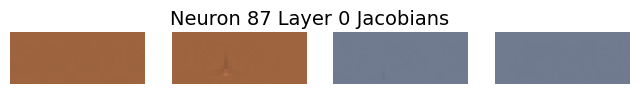

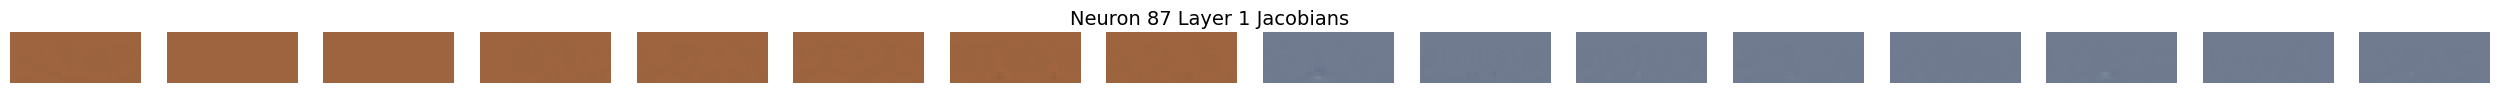

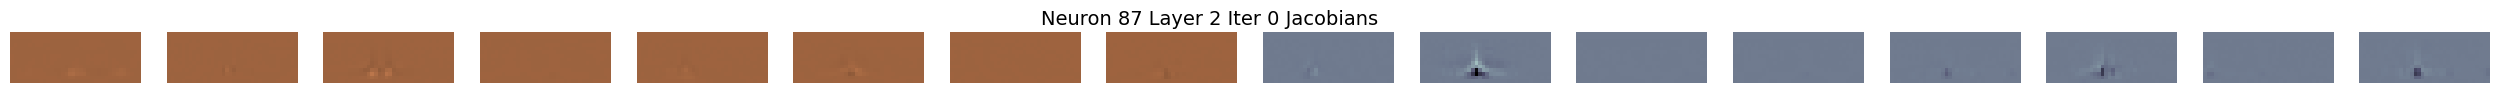

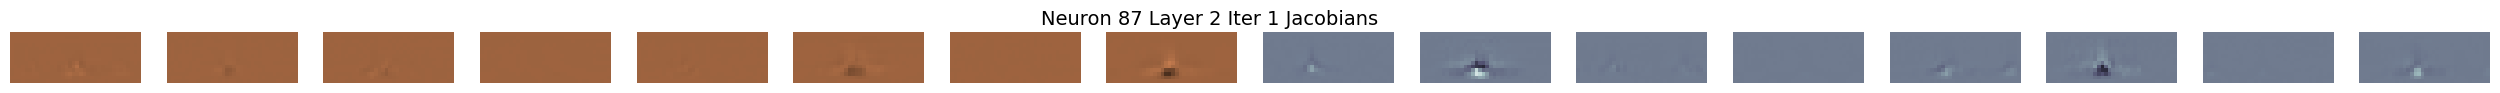

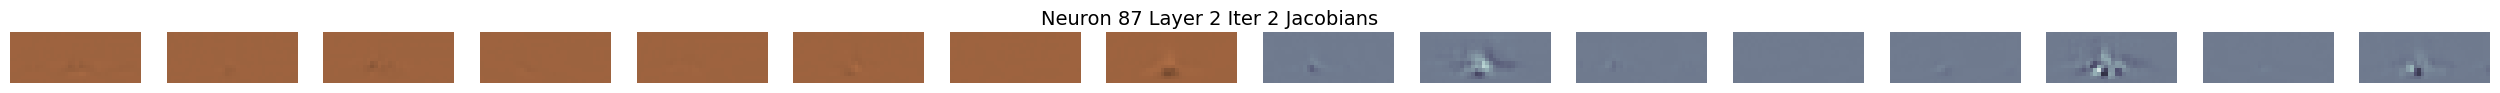

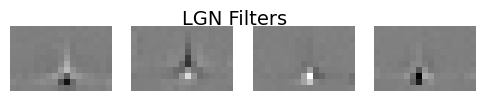

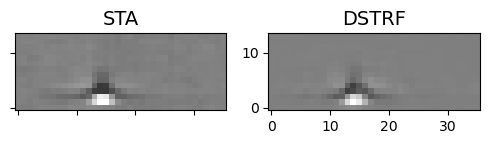

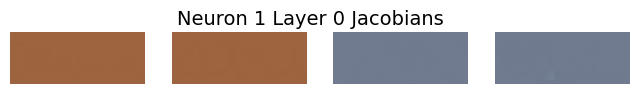

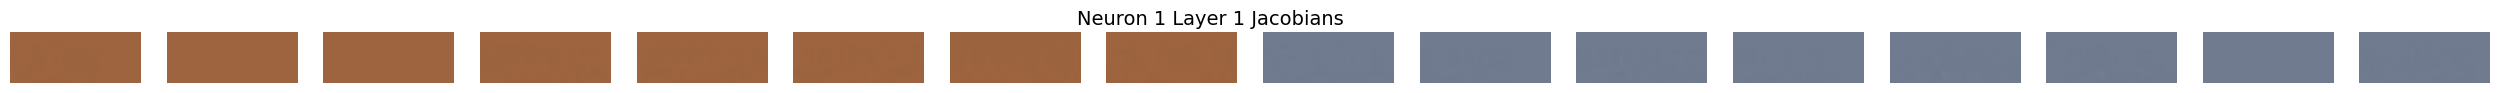

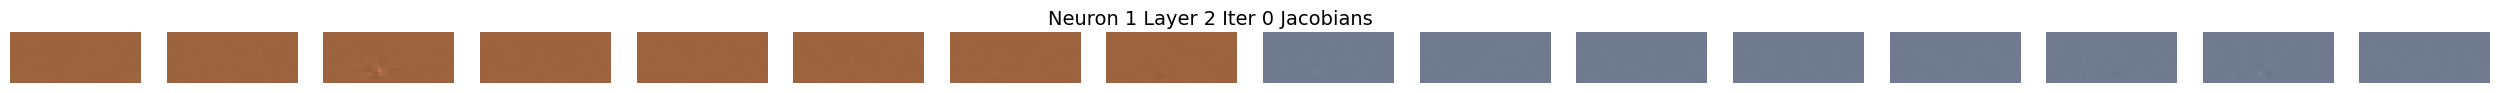

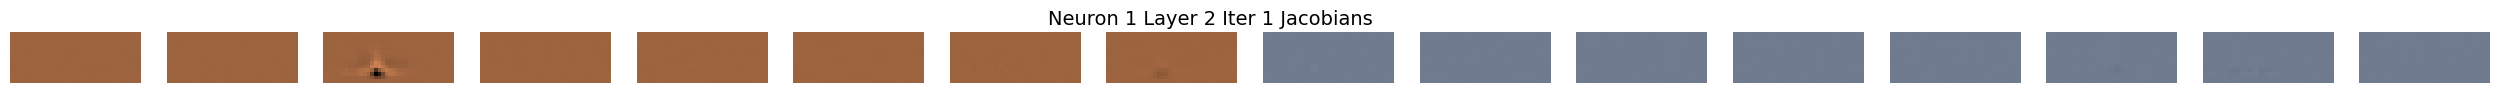

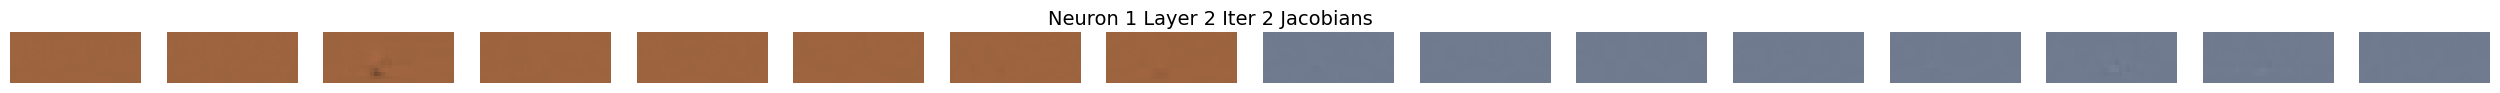

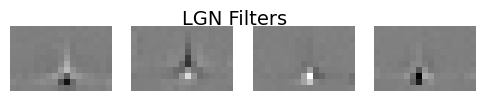

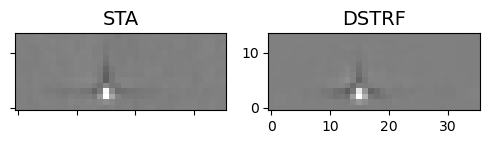

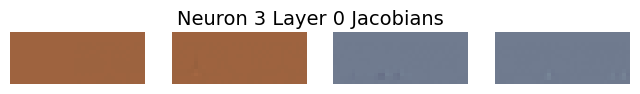

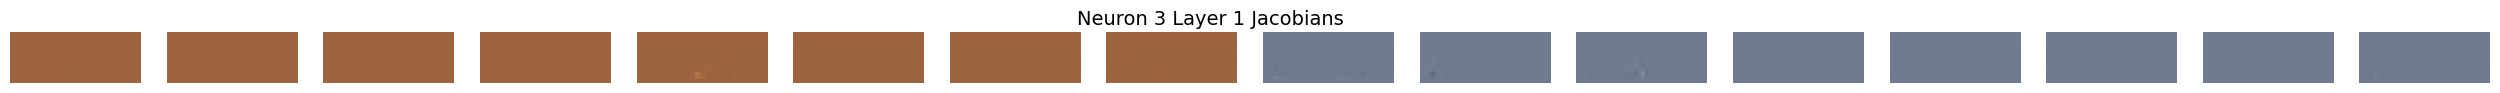

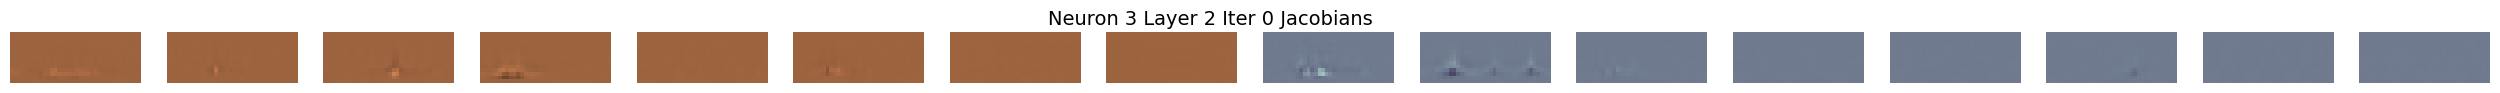

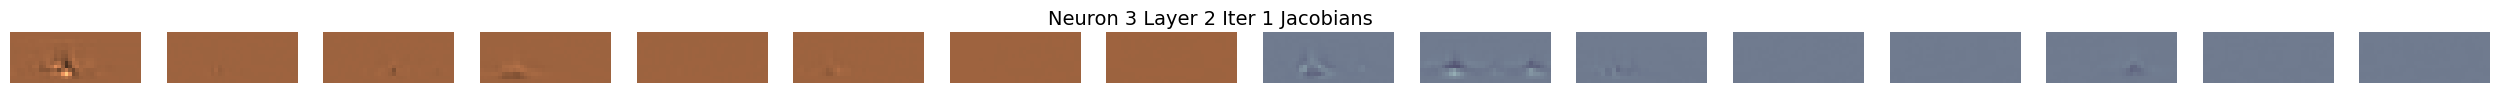

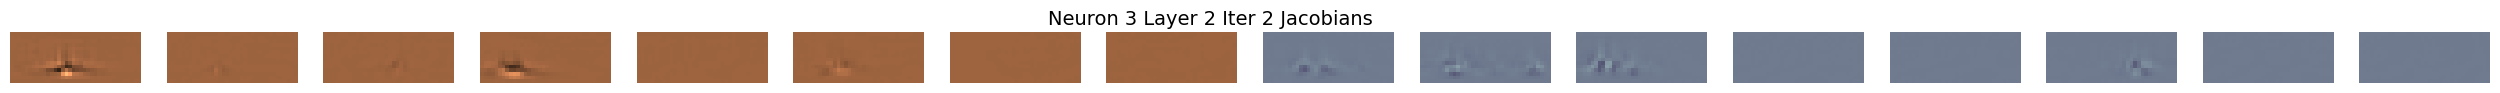

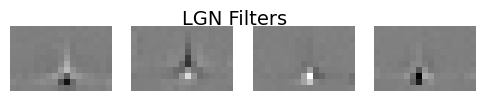

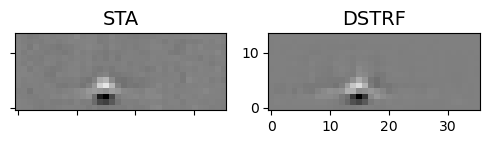

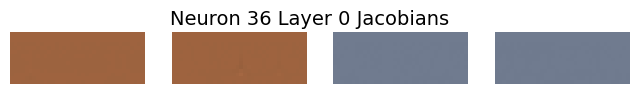

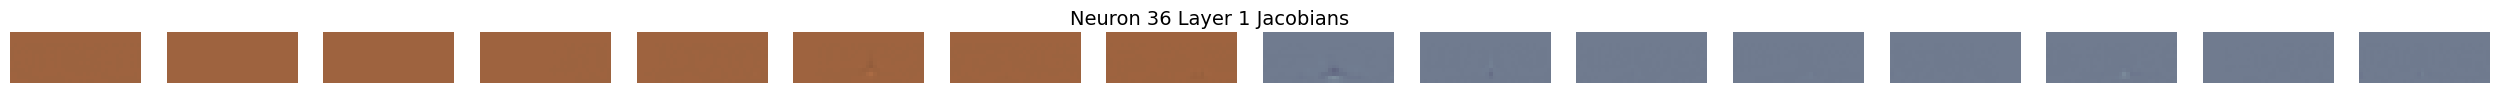

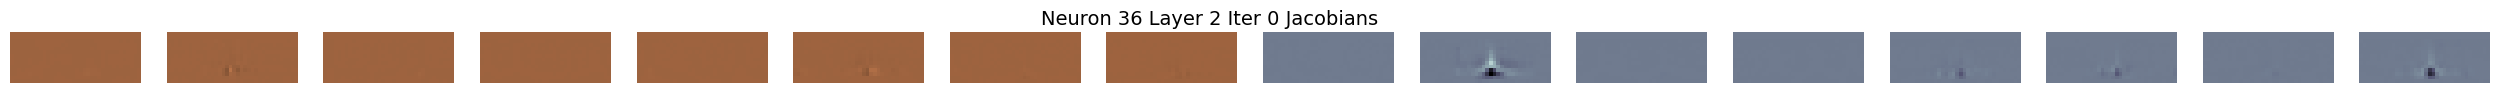

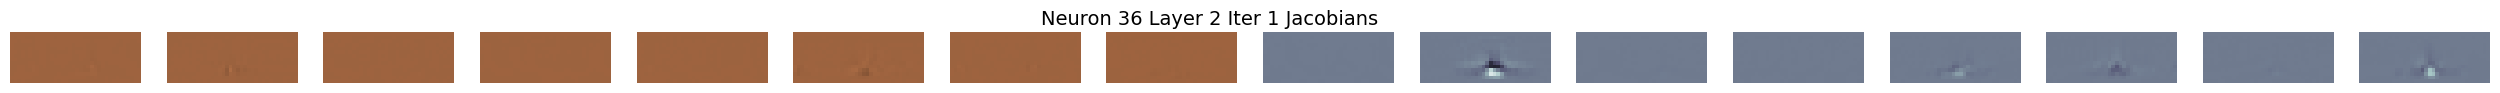

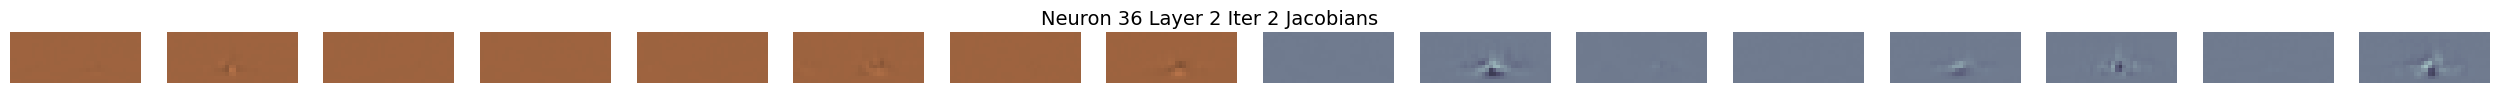

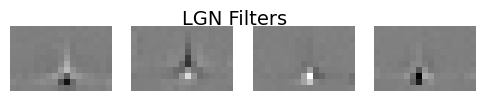

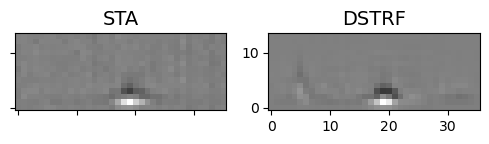

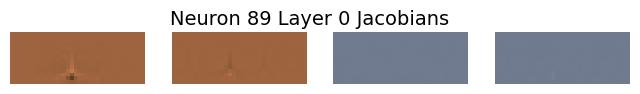

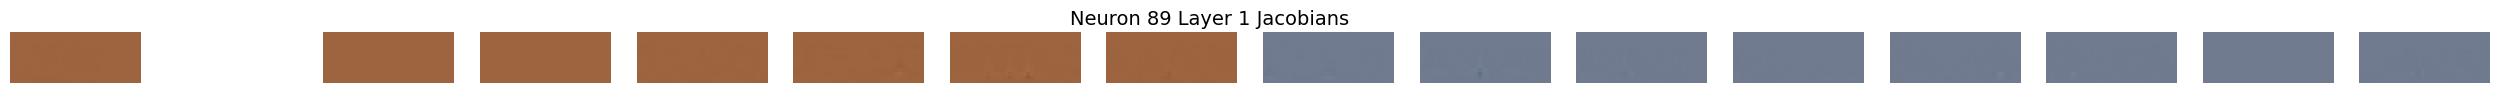

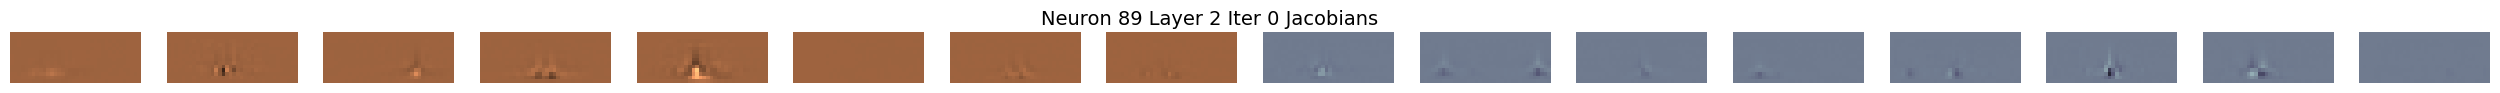

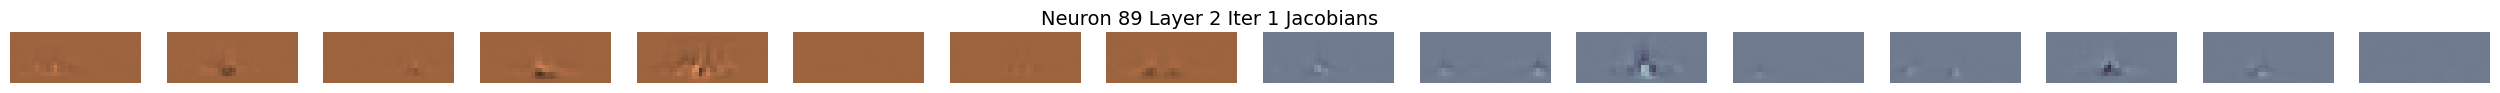

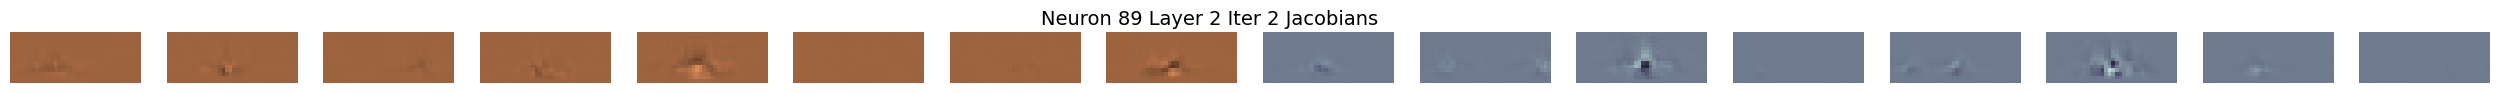

In [46]:
model = e.trials[0].model
neuron_readout_weights = model.networks[-1].layers[-1].weights[:,:,dirsel_neurons]
# normalize the weights
neuron_readout_weights = neuron_readout_weights / np.max(np.abs(neuron_readout_weights))

weighted_jacobians = []
weighted_jacobian_maxes = []
for neuron_idx in range(len(dirsel_neurons)):
    weighted_jacobians_neuron = []
    weighted_jacobian_max_neuron = 0
    neuron = dirsel_neurons[neuron_idx]
    jacobians = results[neuron_idx].jacobians
    
    neuron_readout_weights = model.networks[-1].layers[-1].weights[:,:,neuron_idx]
    
    start_weight_pos = 0
    print('Neuron readout weights shape', neuron_readout_weights.shape)
    for ni in [0]:
        print('Num layers', len(jacobians[ni]))
        for li in range(len(jacobians[ni])): # skip LGN for this one
            if li < 2:
                iters = None
                timepoints, subunits, space, lags, image = jacobians[ni][li].shape
            else:
                timepoints, iters, subunits, space, lags, image = jacobians[ni][li].shape
                
            layer_readout_weights = neuron_readout_weights[start_weight_pos:start_weight_pos+subunits,:]
            print('-->', start_weight_pos, start_weight_pos+subunits)
            start_weight_pos += subunits
            print('Network', ni, 'Layer', li, 'Jacobian shape', jacobians[ni][li].shape, 'Neuron weights shape', neuron_readout_weights.shape)
            # for the last layer, use the number of lags,
            # otherwise, just use the first lag
            
            layer_jacobians = np.mean(jacobians[ni][li], axis=0) # get the jacobian for this neuron
            print('Layer readout weights shape', layer_readout_weights.shape)
            print('Layer Jacobians shape', layer_jacobians.shape)
            
            if iters is None:
                for subunit in range(subunits):
                    # get a weighted sum of the l0_l1_reshaped and the neuron_readout_weights at this neuron
                    # # skip the first 4 going to the LGN
                    weighted_jacobian = layer_readout_weights[subunit,:].T @ layer_jacobians[subunit,:,0,:]
                    weighted_jacobian_max_neuron = max(np.max(np.abs(weighted_jacobian)), weighted_jacobian_max_neuron)
                    weighted_jacobians_neuron.append(weighted_jacobian)
            else:
                print('iters', iters)
                for itr in range(iters):
                    for subunit in range(subunits):
                        # get a weighted sum of the l0_l1_reshaped and the neuron_readout_weights at this neuron
                        # # skip the first 4 going to the LGN
                        weighted_jacobian = layer_readout_weights[subunit,:].T @ layer_jacobians[itr,subunit,:,0,:]
                        weighted_jacobian_max_neuron = max(np.max(np.abs(weighted_jacobian)), weighted_jacobian_max_neuron)
                        weighted_jacobians_neuron.append(weighted_jacobian)
    
    weighted_jacobians.append(weighted_jacobians_neuron)
    weighted_jacobian_maxes.append(weighted_jacobian_max_neuron)
                    
print(len(weighted_jacobians[0]))

# plot the Jacobians with proper min and max
for neuron_idx in range(len(dirsel_neurons)):
    i = 0
    neuron = dirsel_neurons[neuron_idx]
    jacobians = results[neuron_idx].jacobians
    filter_max = np.max(e.trials[0].model.networks[0].layers[0].weights)
    filter_min = -filter_max
    fig = plt.figure(figsize=(6,1))
    num_lgn_filters = model.networks[0].layers[0].weights.shape[2]
    for k in range(num_lgn_filters):
        plt.subplot(1,num_lgn_filters,k+1)
        # plot the weights for the first layer
        plt.imshow(model.networks[0].layers[0].weights[:,:,k].T, cmap='gray', origin='lower', vmin=filter_min, vmax=filter_max)
        plt.axis('off')
    plt.suptitle('LGN Filters', fontsize=14)

    # Calculate STA
    num_lags = 14
    Reff = dataset.robs * dataset.dfs
    nspks = torch.sum(Reff, axis=0)
    stas = (dataset.stim.T@dataset.robs / nspks).reshape([-1, num_lags, dataset.NC]).detach().numpy()
    # plot DSTRF for the neuron 1
    fig = plt.figure(figsize=(6,1))
    plt.subplot(1,2,1)
    plot.imagesc(stas[:, :, neuron], aspect='auto', cmap='gray_r', colrow=True, axis_labels=False)
    plt.title('STA', fontsize=14)
    plt.subplot(1,2,2)
    plot.imagesc(np.mean(jacobians[-1][-1][:,neuron,:], axis=0).reshape(36,14), cmap='gray_r', origin='lower')
    plt.title('DSTRF', fontsize=14)
    for ni in [0]:
        for li in range(len(jacobians[ni])): # skip LGN for this one
            if li < 2:
                iters = None
                timepoints, subunits, space, lags, image = jacobians[ni][li].shape
            else:
                timepoints, iters, subunits, space, lags, image = jacobians[ni][li].shape
                
            if iters is None:
                fig = plt.figure(figsize=(subunits*2,1))
                for subunit in range(subunits):
                    plt.subplot(1,subunits,subunit+1)
                    if subunit >= subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'
                    plt.imshow(weighted_jacobians[neuron_idx][i].reshape(36,14).T, cmap=cmap, origin='lower', 
                               vmin=-weighted_jacobian_maxes[neuron_idx], vmax=weighted_jacobian_maxes[neuron_idx])
                    plt.axis('off')
                    # draw a vertical line at the center of the receptive field
                    #plt.axvline(x=17, color='white', linestyle='--', alpha=0.5)
                    i += 1
                    plt.suptitle('Neuron ' + str(neuron) + ' Layer ' + str(li) + ' Jacobians', fontsize=14)
            else:
                for itr in range(iters):
                    fig = plt.figure(figsize=(subunits*2,1))
                    for subunit in range(subunits):
                        plt.subplot(1,subunits,subunit+1)
                        if subunit >= subunits//2: # inhibitory subunits
                            cmap = 'bone'
                        else:
                            cmap = 'copper'
                        plt.imshow(weighted_jacobians[neuron_idx][i].reshape(36,14).T, cmap=cmap, origin='lower', 
                                   vmin=-weighted_jacobian_maxes[neuron_idx], vmax=weighted_jacobian_maxes[neuron_idx])
                        plt.axis('off')
                        # draw a vertical line at the center of the receptive field
                        #plt.axvline(x=17, color='white', linestyle='--', alpha=0.5)
                        i += 1
                    plt.suptitle('Neuron ' + str(neuron) + ' Layer ' + str(li) + ' Iter ' + str(itr) + ' Jacobians', fontsize=14)

# readout quantifications

In [212]:
# TODO: compare lag-wise activations across the layers for the direction selective neurons to the non-direction selective neurons

Readout weights shape (66, 36, 111)


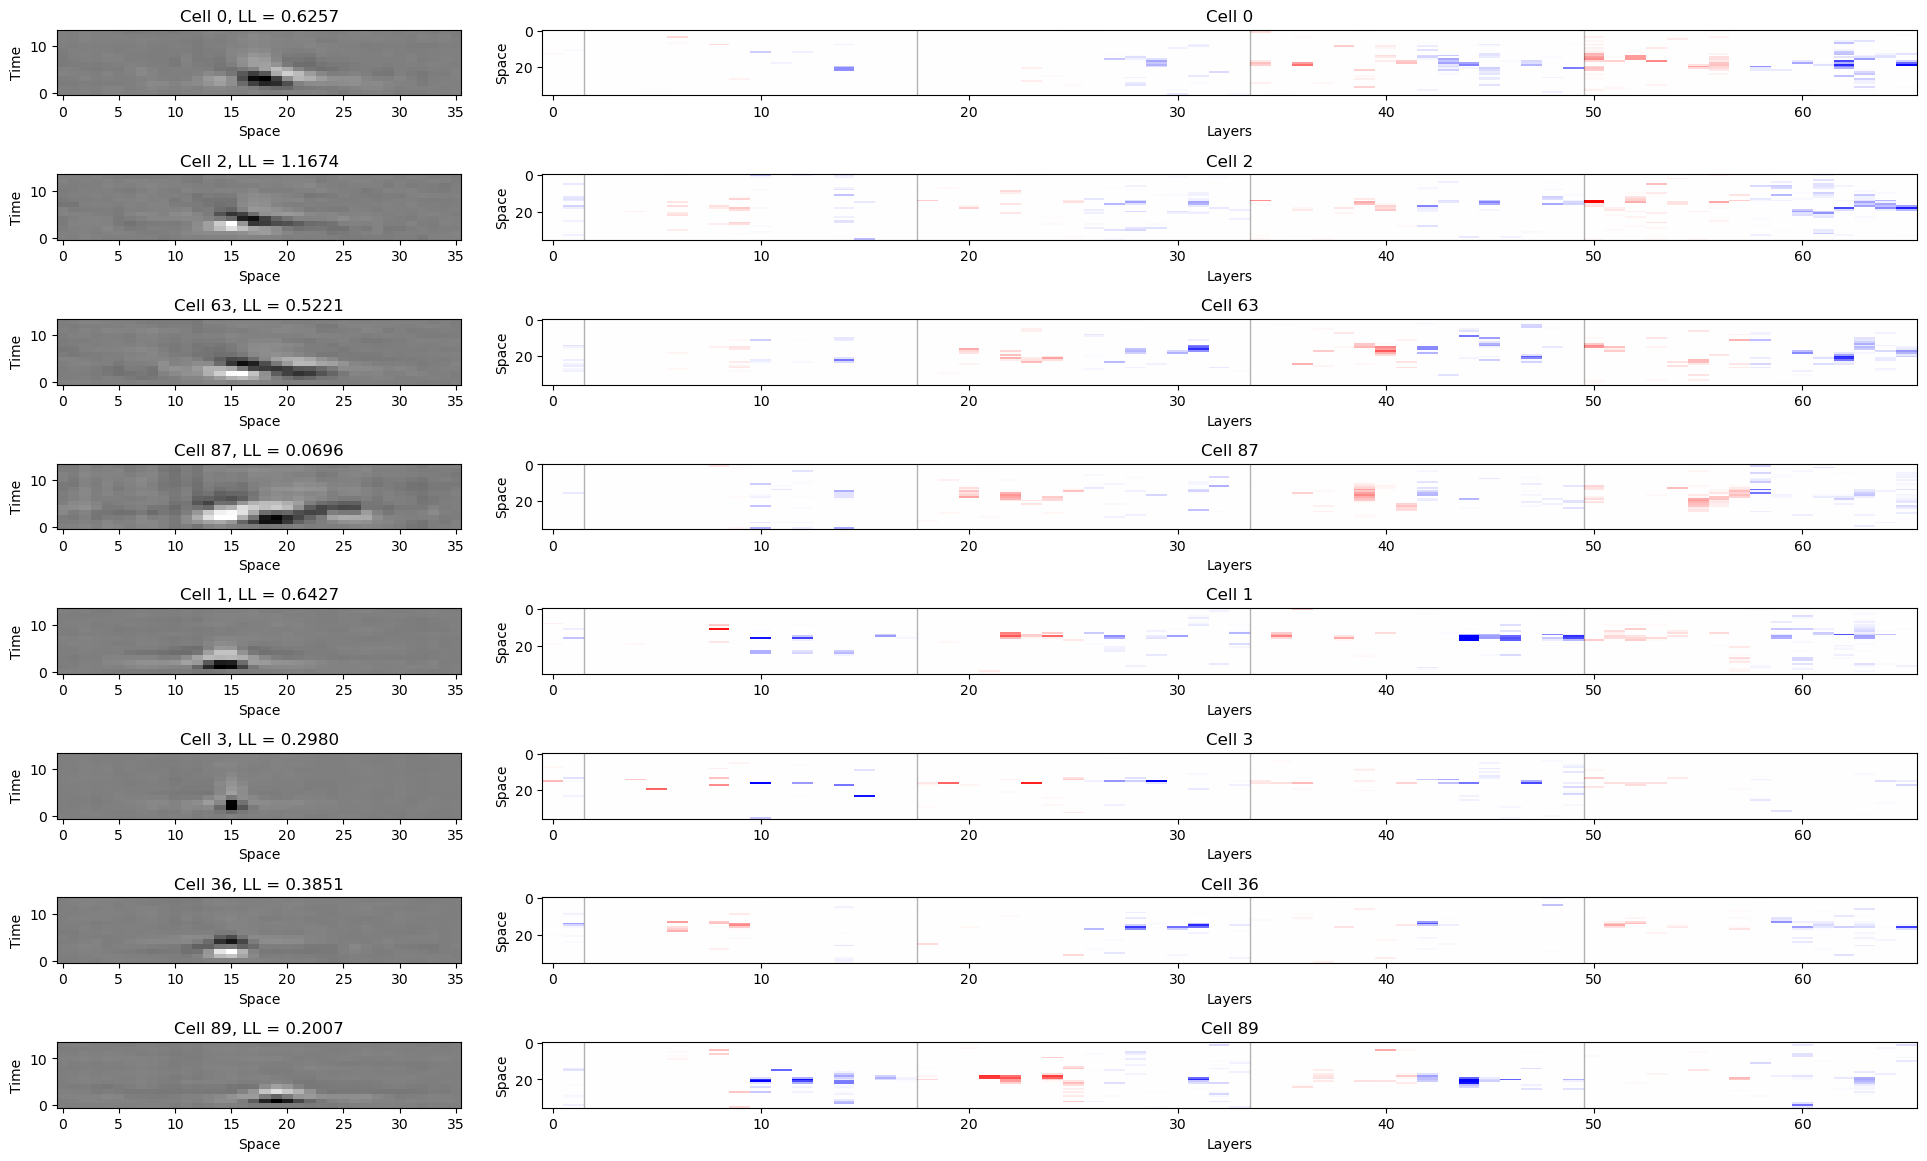

In [222]:
# get the weights
readout_weights = e.trials[0].model.networks[1].layers[0].weights
print('Readout weights shape', readout_weights.shape)
readout_weights[1,:,:] = -readout_weights[1,:,:]
for i in range(10,readout_weights.shape[0],16):
    readout_weights[i:i+8,:,:] = -readout_weights[i:i+8,:,:]

pred_max = np.max(pred[:,:,dirsel_neurons])
pred_min = -pred_max

readout_max = np.max(readout_weights[:,:,dirsel_neurons])
readout_min = -readout_max

fig = plt.figure(figsize=(24,14))
rows,cols = len(dirsel_neurons),4
gridspec = fig.add_gridspec(rows,cols)
# put vertical space between the plots
gridspec.update(wspace=0.2, hspace=1.2)

cc = 0
for cc in range(len(dirsel_neurons)):
    ax = fig.add_subplot(gridspec[cc,0])
    plot.imagesc(pred[:,:,dirsel_neurons[cc]], cmap='gray', ax=ax)
    ax.set_title('Cell '+str(dirsel_neurons[cc])+', LL = %.4f' % e.trials[0].LLs[dirsel_neurons[cc]])
    ax.set_xlabel('Space')
    ax.set_ylabel('Time')

    ax = fig.add_subplot(gridspec[cc,1:])
    ax.imshow(readout_weights[:,:,dirsel_neurons[cc]].T, cmap='bwr', aspect='auto', vmin=readout_min, vmax=readout_max, interpolation='none')
    ax.set_xlabel('Layers')
    ax.set_ylabel('Space')
    ax.set_title('Cell '+str(dirsel_neurons[cc]))

    # draw a vertical line between each layer
    for layer_boundary in layer_boundaries[1:-1]:
        # shift the line back by 0.5
        ax.axvline(layer_boundary-0.5, color='k', linewidth=1, alpha=0.3)

    cc += 1

In [215]:
# quantify the relative amount of excitatory and inhibitory weights across the layers for each neuron
readout_weights.shape, np.sum(readout_weights[10:18,:,dirsel_neurons[:4]], axis=(0,1))

((66, 36, 111),
 array([-1.2622925, -1.46168  , -1.1463182, -1.999385 ], dtype=float32))

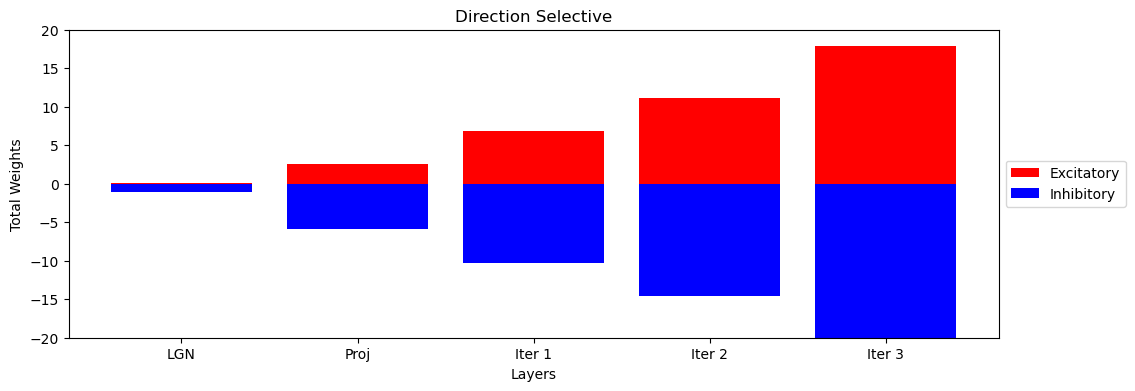

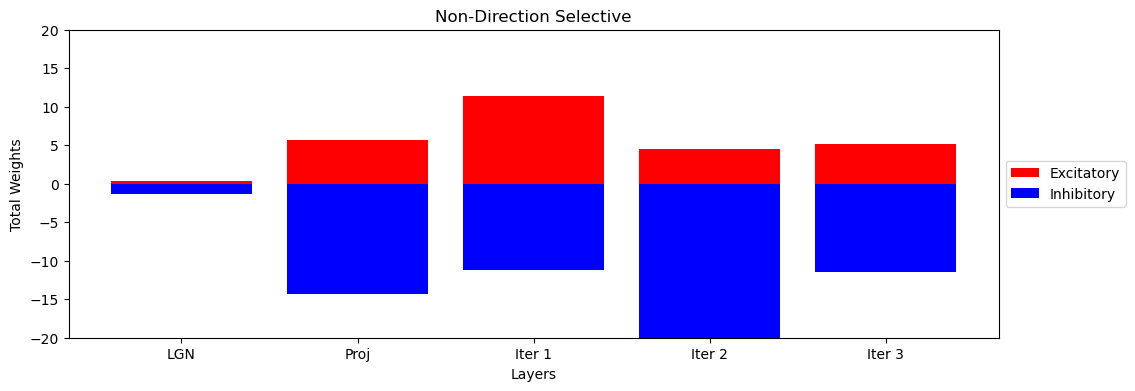

In [223]:
# sum up every 8 units to get the total exc and inh weights
dir_exc = [np.sum(readout_weights[0,:,dirsel_neurons[:4]])]
dir_inh = [np.sum(readout_weights[1,:,dirsel_neurons[:4]])]
non_exc = [np.sum(readout_weights[0,:,dirsel_neurons[4:]])]
non_inh = [np.sum(readout_weights[1,:,dirsel_neurons[4:]])]
for i in range(2,readout_weights.shape[0],16):
    dir_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[:4]]))
    dir_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[:4]]))
    non_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[4:]]))
    non_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[4:]]))

# plot the bar plots for the direction selective and non-direction selective neurons across layers
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), dir_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), dir_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Direction Selective')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), non_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), non_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Non-Direction Selective')
# put the legend on the left side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Direction selective excitatory weights (4,)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (5, 4).

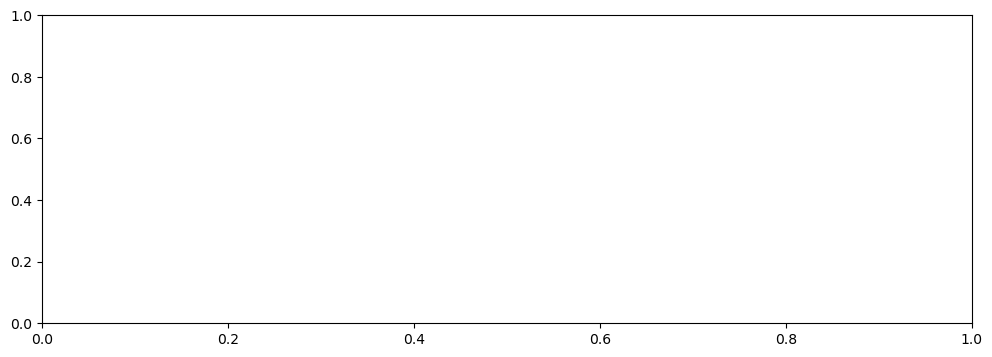

In [220]:
# sum up every 8 units to get the total exc and inh weights
dir_exc = [np.sum(readout_weights[0,:,dirsel_neurons[:4]], axis=1)]
dir_inh = [np.sum(readout_weights[1,:,dirsel_neurons[:4]], axis=1)]
non_exc = [np.sum(readout_weights[0,:,dirsel_neurons[4:]], axis=1)]
non_inh = [np.sum(readout_weights[1,:,dirsel_neurons[4:]], axis=1)]
for i in range(2,readout_weights.shape[0],16):
    dir_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[:4]], axis=(0,1)))
    dir_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[:4]], axis=(0,1)))
    non_exc.append(np.sum(readout_weights[i:i+8,:,dirsel_neurons[4:]], axis=(0,1)))
    non_inh.append(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[4:]], axis=(0,1)))

print('Direction selective excitatory weights', dir_exc[2].shape)

# plot a histogram of the total weights for each neuron across the layers




# plot the bar plots for the direction selective and non-direction selective neurons across layers
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), dir_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), dir_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Direction Selective')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), non_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), non_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Non-Direction Selective')
# put the legend on the left side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# quantify the spatial extent of the weights (second dimension of the readout_weights) similar to the above

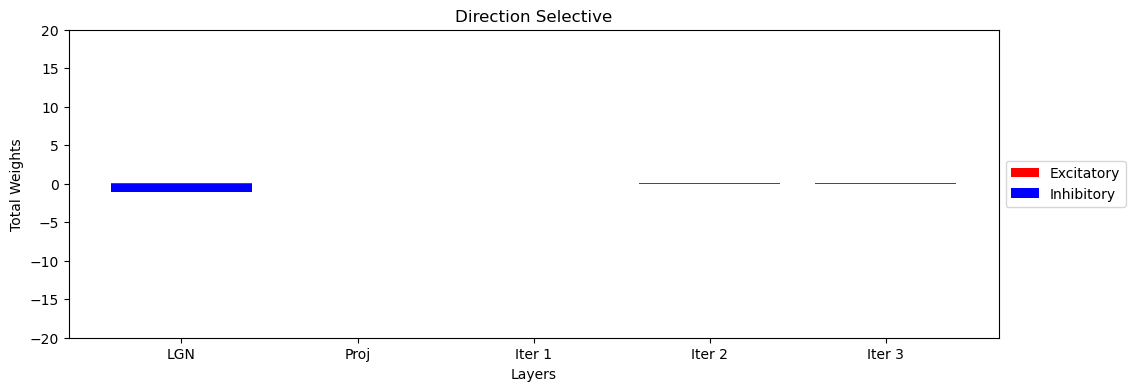

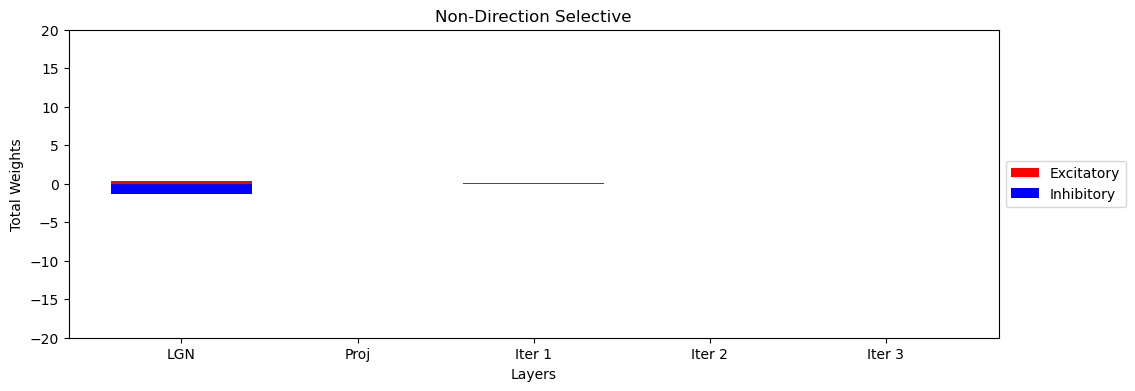

In [208]:
# sum up every 8 units to get the total exc and inh weights
dir_exc = [np.sum(readout_weights[0,:,dirsel_neurons[:4]])]
dir_inh = [np.sum(readout_weights[1,:,dirsel_neurons[:4]])]
non_exc = [np.sum(readout_weights[0,:,dirsel_neurons[4:]])]
non_inh = [np.sum(readout_weights[1,:,dirsel_neurons[4:]])]
for i in range(2,readout_weights.shape[0],16):
    dir_exc.append(np.mean(np.sum(readout_weights[i:i+8,:,dirsel_neurons[:4]], axis=2)))
    dir_inh.append(np.mean(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[:4]], axis=2)))
    non_exc.append(np.mean(np.sum(readout_weights[i:i+8,:,dirsel_neurons[4:]], axis=2)))
    non_inh.append(np.mean(np.sum(readout_weights[i+8:i+16,:,dirsel_neurons[4:]], axis=2)))
    
# plot the bar plots for the direction selective and non-direction selective neurons across layers
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), dir_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), dir_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Direction Selective')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(1,6), non_exc, color='r', label='Excitatory')
ax.bar(np.arange(1,6), non_inh, color='b', label='Inhibitory')
ax.set_xticks(np.arange(1,6))
ax.set_xticklabels(['LGN', 'Proj', 'Iter 1', 'Iter 2', 'Iter 3'])
ax.set_ylim([-20, 20])
ax.set_ylabel('Total Weights')
ax.set_xlabel('Layers')
ax.set_title('Non-Direction Selective')
# put the legend on the left side
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


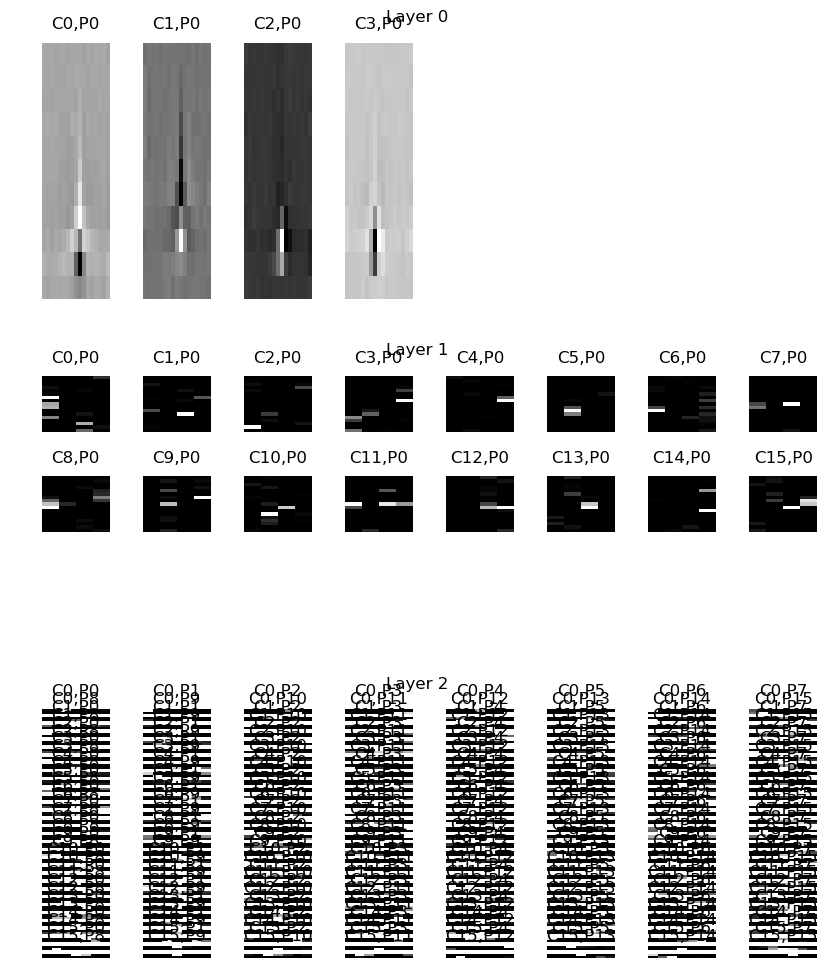

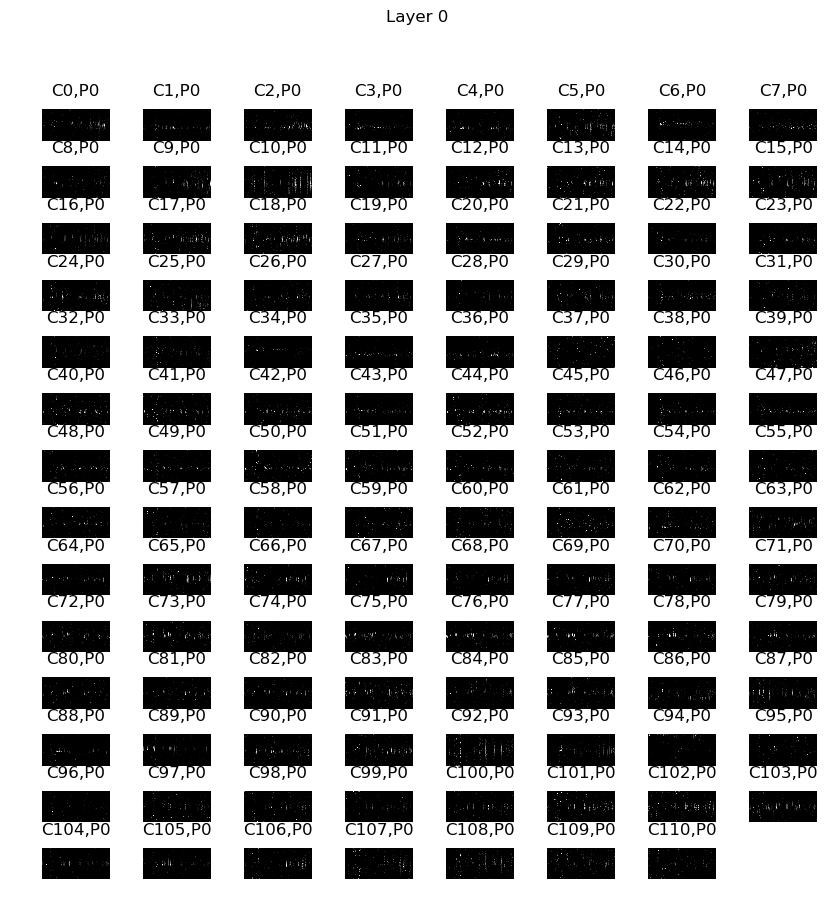

In [26]:
plot.plot_model_weights(e.trials[0].model)

# subunit jacobians

In [7]:
results_outputs = predict.predict(e.trials[0].model, dataset=dataset[:2], calc_jacobian=True, verbose=False, max_network_and_layer=(0,2))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]
/home/mattjac/projects/mattjac/v1/./lib/predict.py:161: RuntimeWarning: divide by zero encountered in divide
  r2 = 1 - np.sum((robs - pred)**2, axis=0) / np.sum((robs - np.mean(robs))**2, axis=0)


In [191]:
e.trials[0].model.NDN.networks[0].layers[2].output_dims

[48, 36, 1, 1]

2


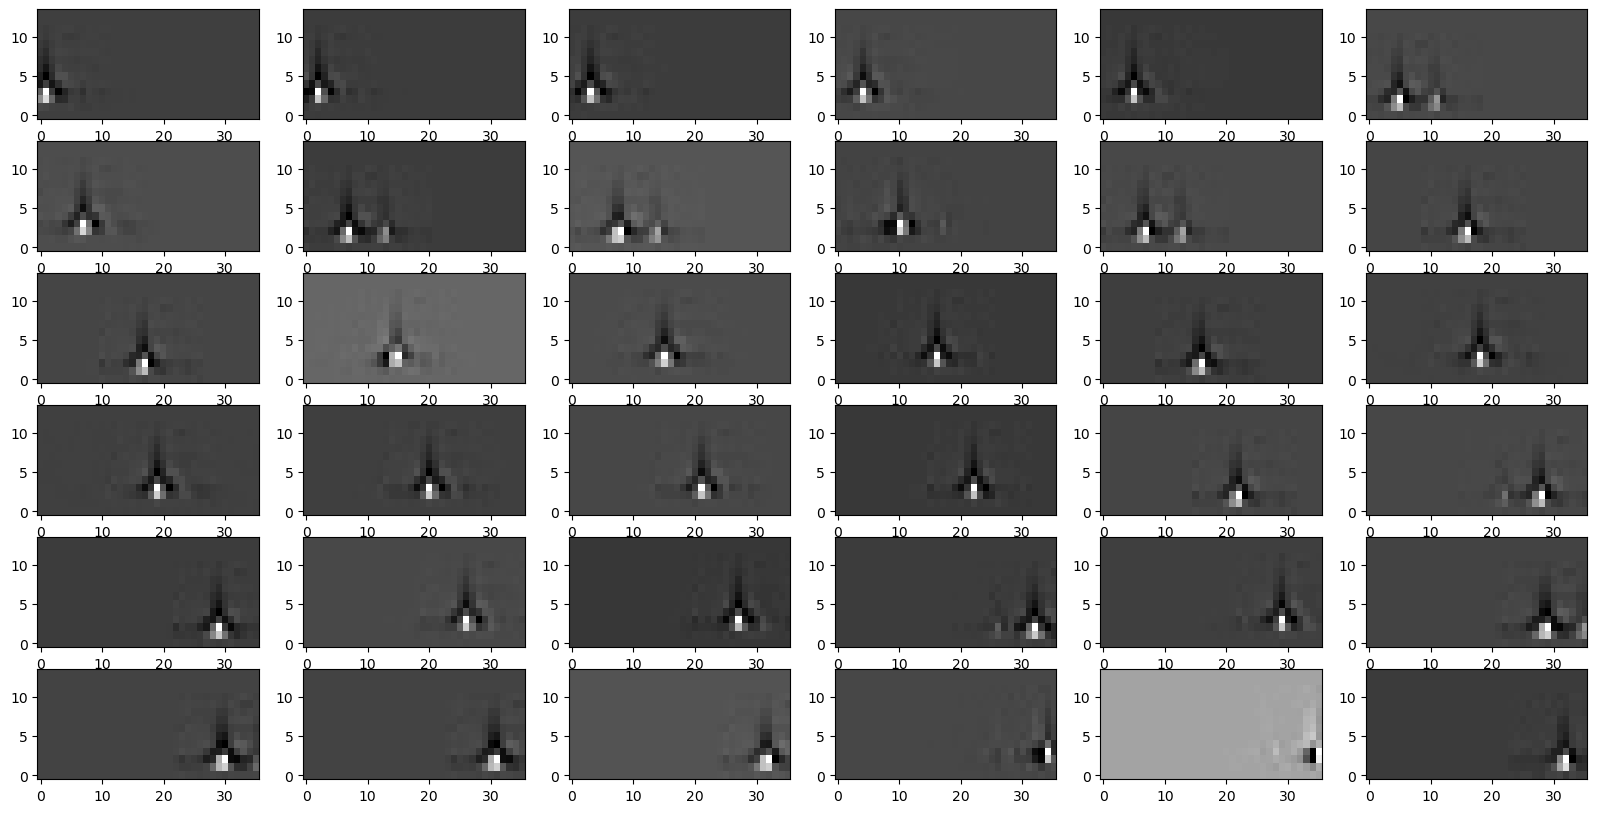

In [193]:
print(len(results_outputs.jacobians[0][0]))
# make a 2x5 gridspec
fig = plt.figure(figsize=(20,10))
for i in [0]:
    gs = matplotlib.gridspec.GridSpec(6,6)
    for x in range(36):
        ax = fig.add_subplot(gs[x])
        #im = results_outputs.jacobians[0][0][i].reshape(2,36,4,36,14)
        im = results_outputs.jacobians[0][0][i].reshape(3,16,36,36,14)
        #ax.imshow(im[0,x,2,:,:].T, aspect='auto', cmap='gray', origin='lower')
        ax.imshow(im[0,0,x,0,:,:].T, aspect='auto', cmap='gray', origin='lower')

# subunit outputs

In [16]:
# look at DSTRFs in the subunits when they are activated

# is the DSTRF higher when the subunit is activated?
# get the outputs for the experiment
end = 100000
results_outputs = predict.predict(e.trials[0].model, dataset=dataset[:end], calc_jacobian=False, verbose=True)

num_inps 100000
prev_output shape torch.Size([100000, 504]) ni 0 NetworkType.scaffold li 0
torch.Size([100000, 504]) --> torch.Size([100000, 576])
prev_output shape torch.Size([100000, 576]) ni 0 NetworkType.scaffold li 1
torch.Size([100000, 576]) --> torch.Size([100000, 2304])
prev_output shape torch.Size([100000, 2304]) ni 0 NetworkType.scaffold li 2
torch.Size([100000, 2304]) --> torch.Size([100000, 1728])
prev_output shape torch.Size([100000, 2448]) ni 1 NetworkType.normal li 0
torch.Size([100000, 2448]) --> torch.Size([100000, 111])


In [9]:
import pickle
#with open('results_iter_exps12_3iters_outputs.pkl', 'wb') as f:
#    pickle.dump(results_outputs, f)

with open('results_iter_exps12_3iters_outputs.pkl', 'rb') as f:
    results_outputs = pickle.load(f)

In [10]:
class ResultsJacobian:
    def __init__(self, jacobian, times):
        self.jacobian = jacobian
        self.times = times
        
results_jacobians = []

for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
        #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
        #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
        #    continue # skip if already done
        if li < 2:
            num_subunits = results_outputs.outputs[ni][li].shape[1]
            for subunit in range(num_subunits):
                if subunit < num_subunits // 2:
                    times = np.argsort(results_outputs.outputs[ni][li][:,subunit,17,0].flatten(), axis=0)[-10:]
                else:
                    times = np.argsort(results_outputs.outputs[ni][li][:,subunit,17,0].flatten(), axis=0)[:10]
                jacobian = predict.predict(e.trials[0].model, dataset=dataset[times], calc_jacobian=True, verbose=False, max_network_and_layer=(ni,li))
                results_jacobian = ResultsJacobian(jacobian, times)
                results_jacobians.append(results_jacobian)
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                num_subunits = results_outputs.outputs[ni][li].shape[2]
                for subunit in range(num_subunits):
                    if subunit < num_subunits // 2:
                        times = np.argsort(results_outputs.outputs[ni][li][:,iter,subunit,17,0].flatten(), axis=0)[-10:]
                    else:
                        times = np.argsort(results_outputs.outputs[ni][li][:,iter,subunit,17,0].flatten(), axis=0)[:10]
                    jacobian = predict.predict(e.trials[0].model, dataset=dataset[times], calc_jacobian=True, verbose=False, max_network_and_layer=(ni,li))
                    results_jacobian = ResultsJacobian(jacobian, times)
                    results_jacobians.append(results_jacobian)
        
        # save the top outputs
        #with open('./results_iter_exps12_3iters_jacobians/'+fname, 'wb') as f:
        #    pickle.dump(results_jacobian, f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.44it/s]


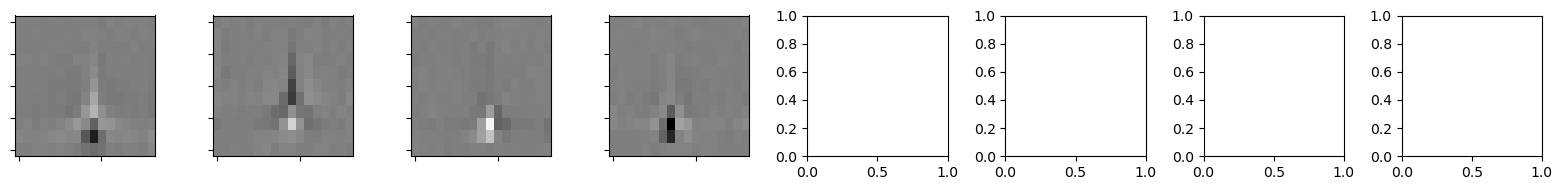

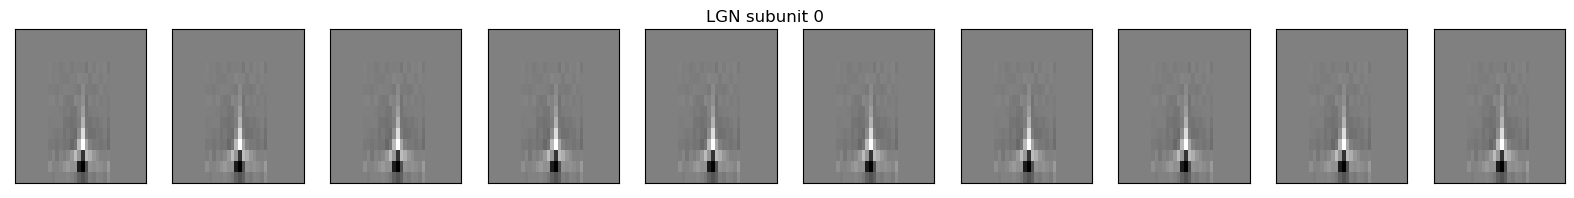

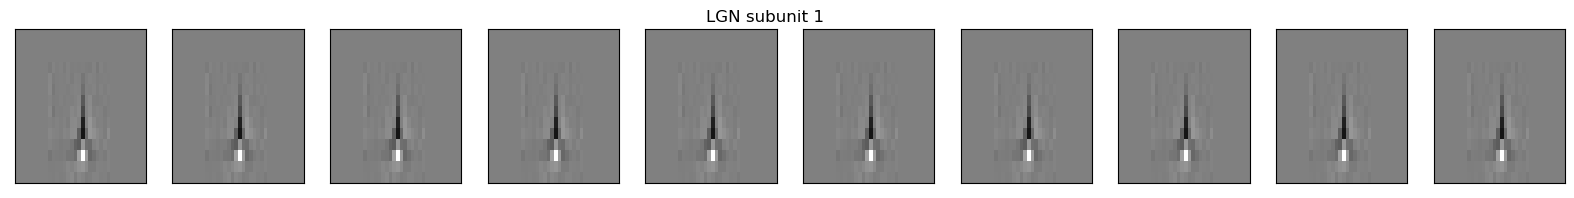

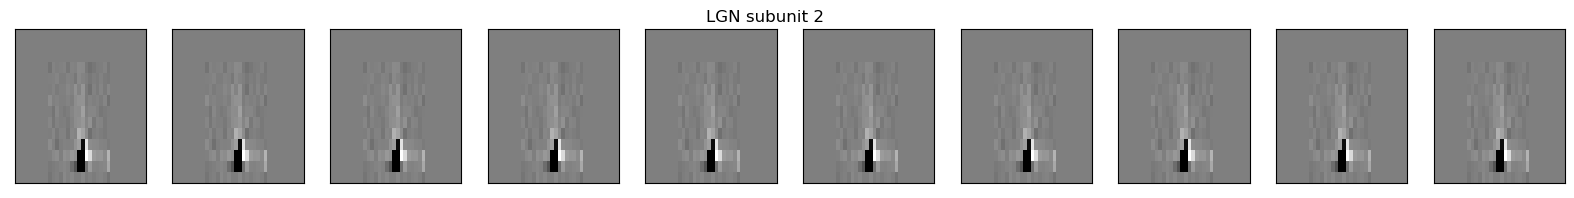

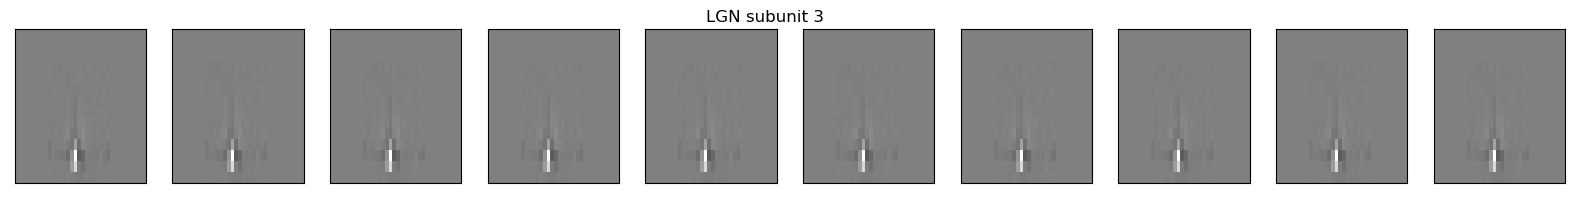

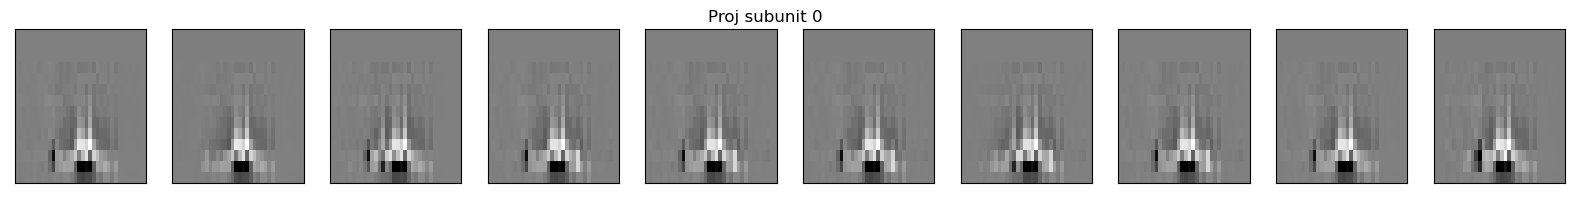

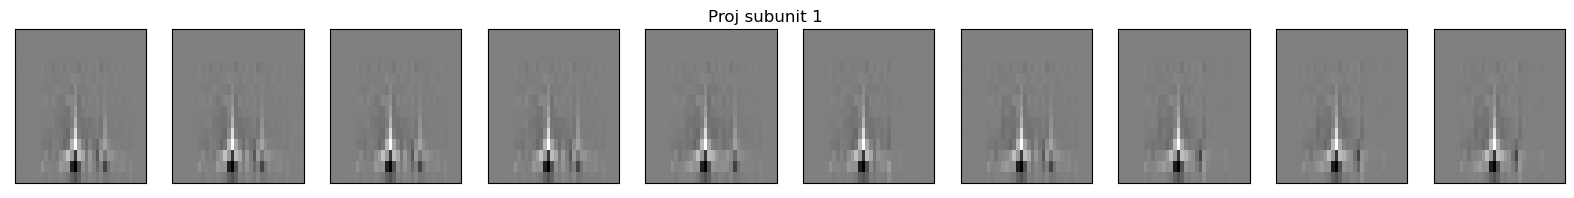

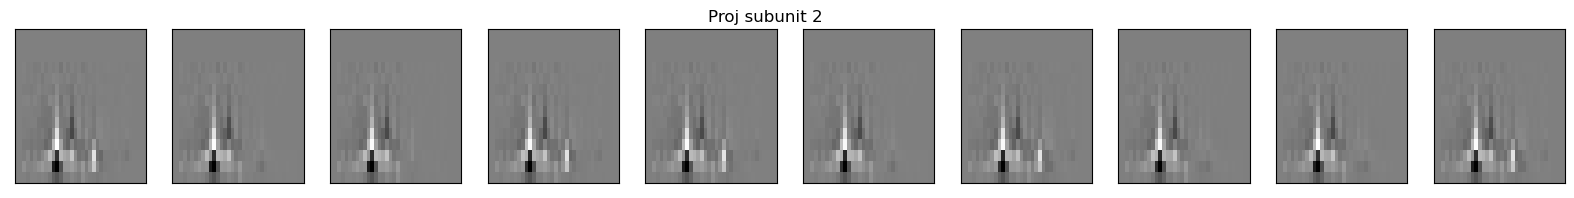

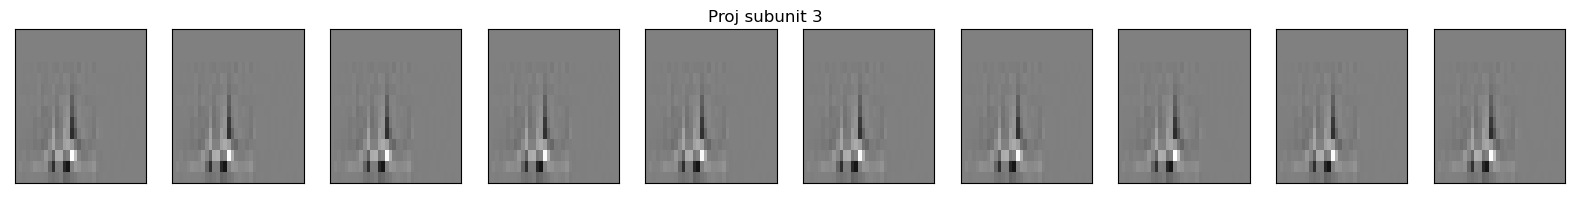

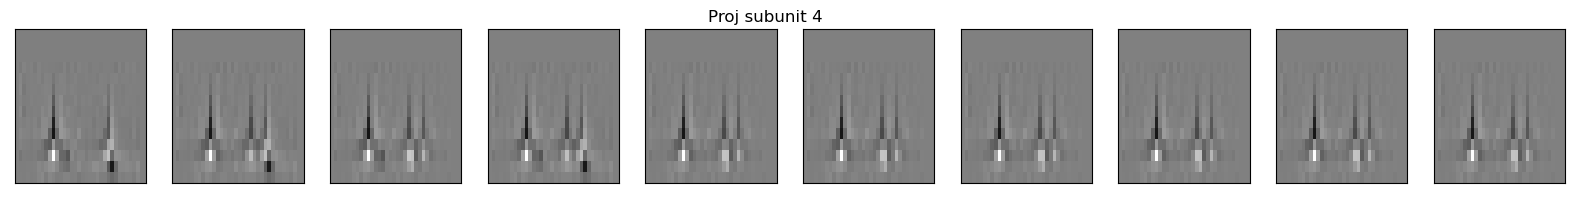

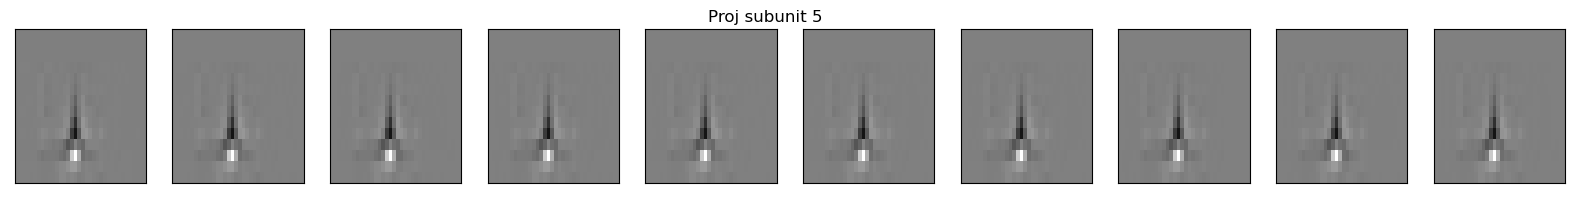

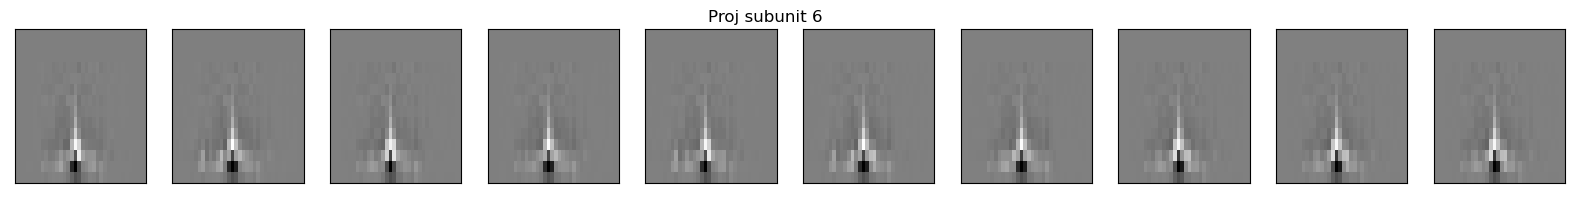

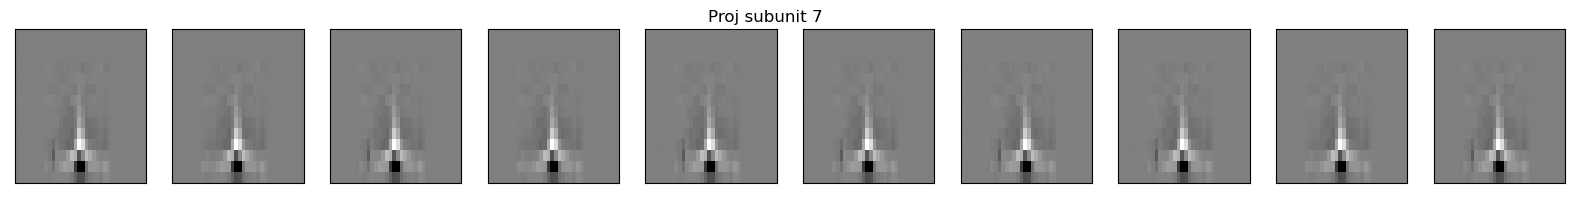

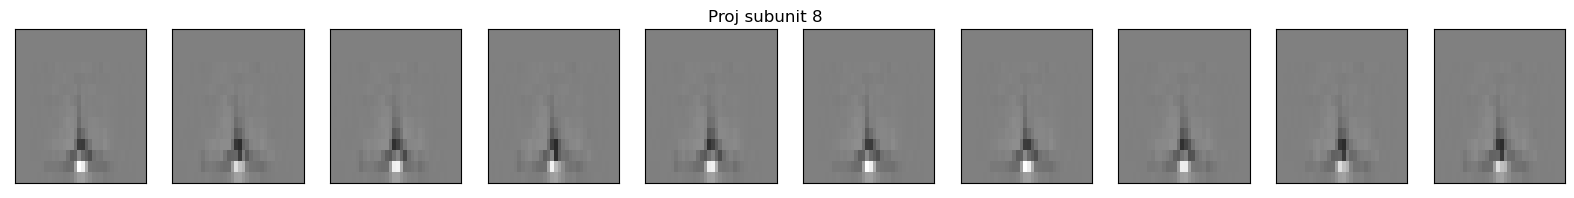

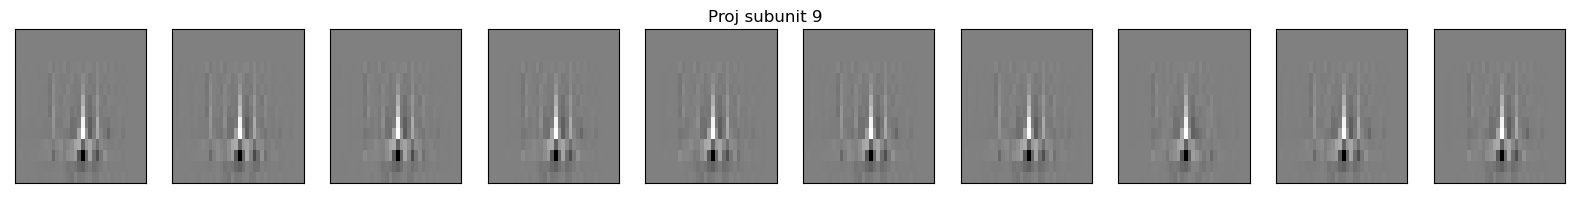

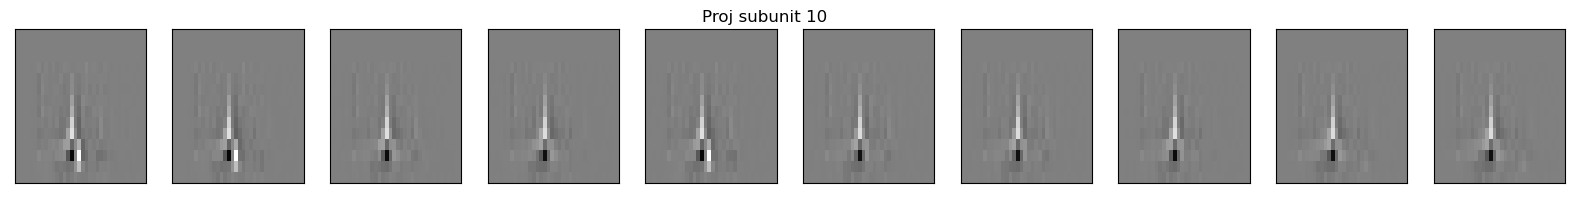

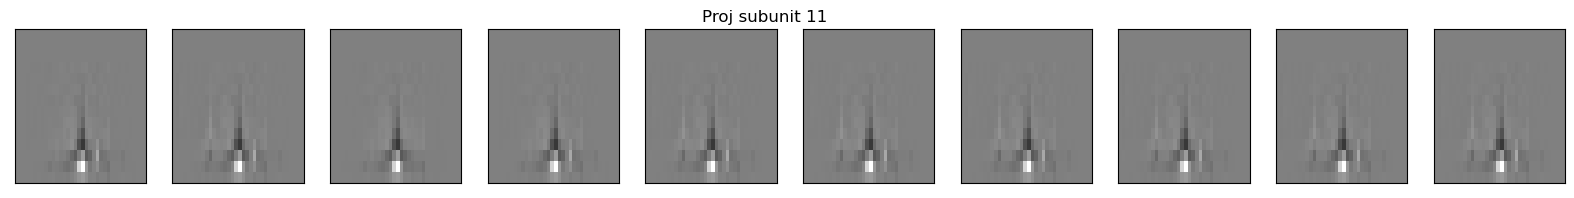

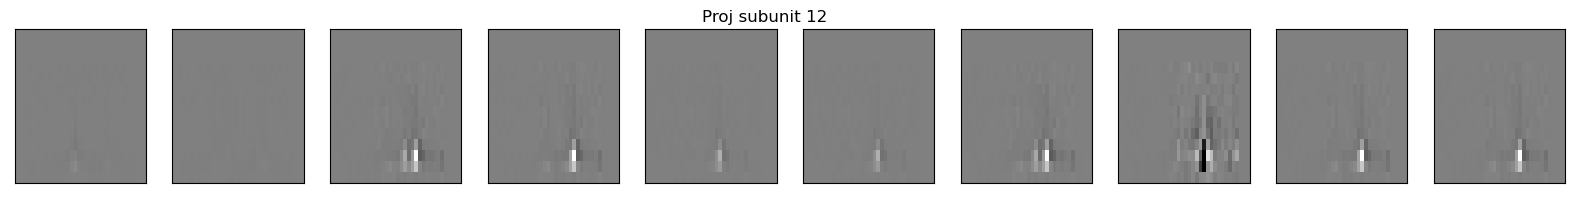

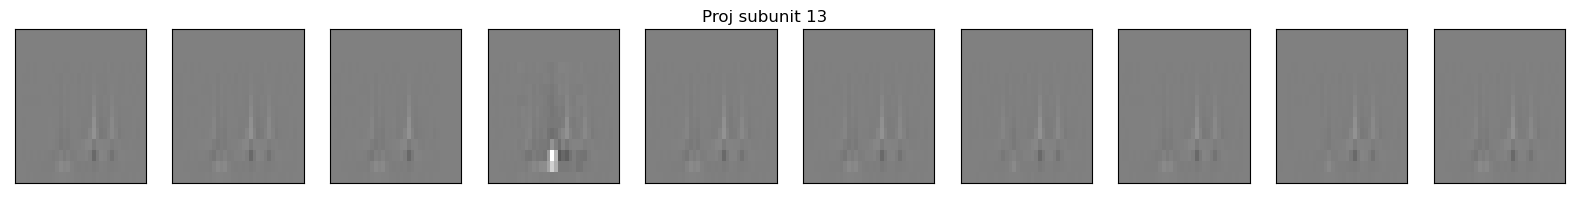

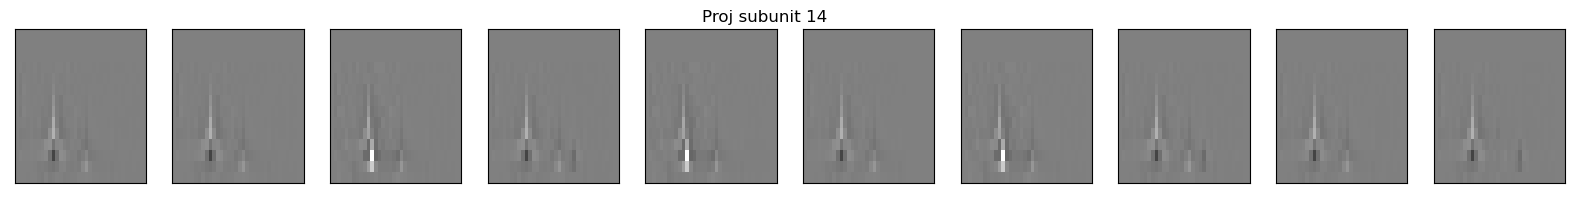

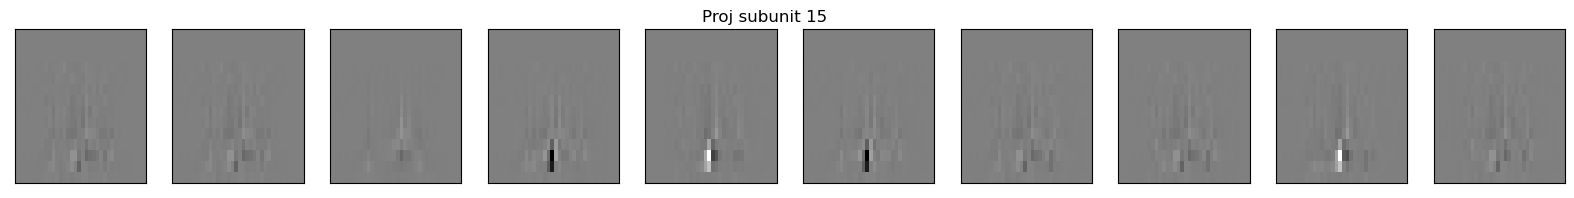

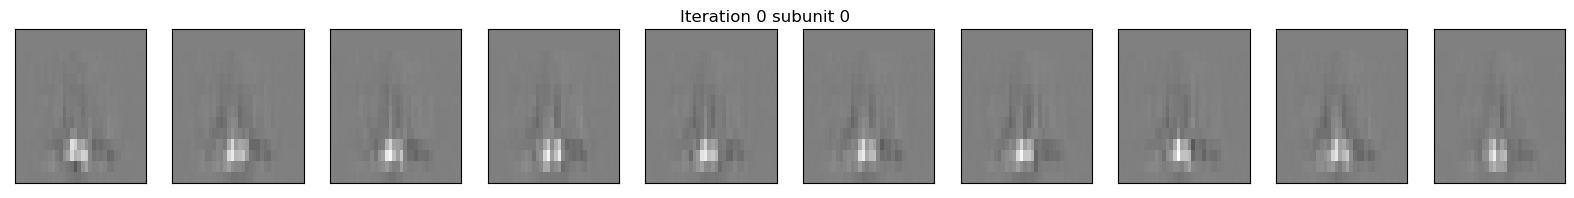

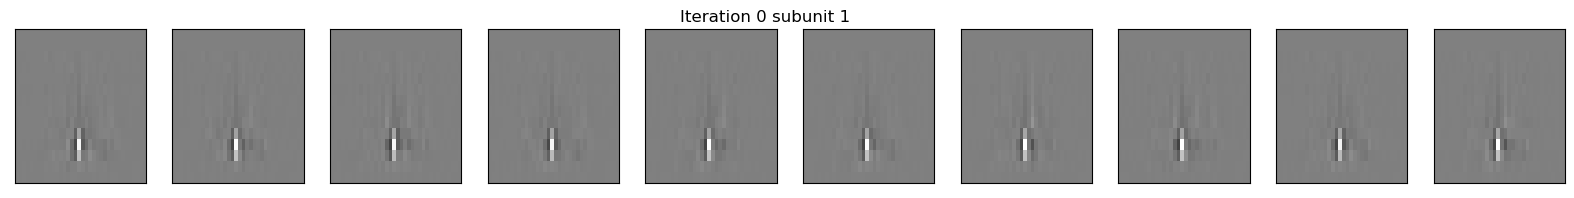

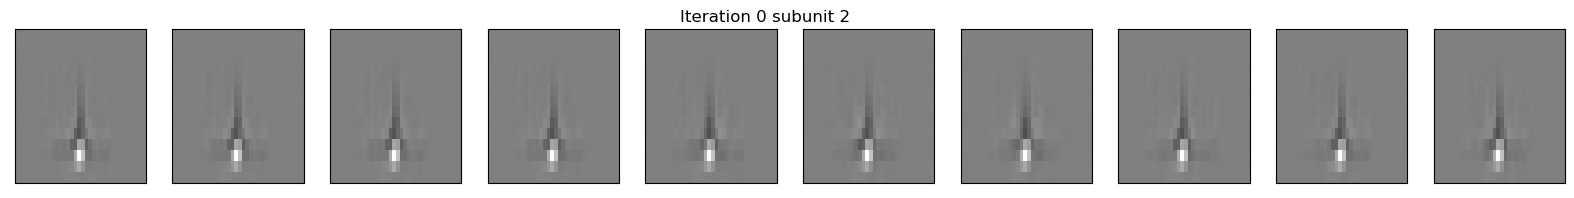

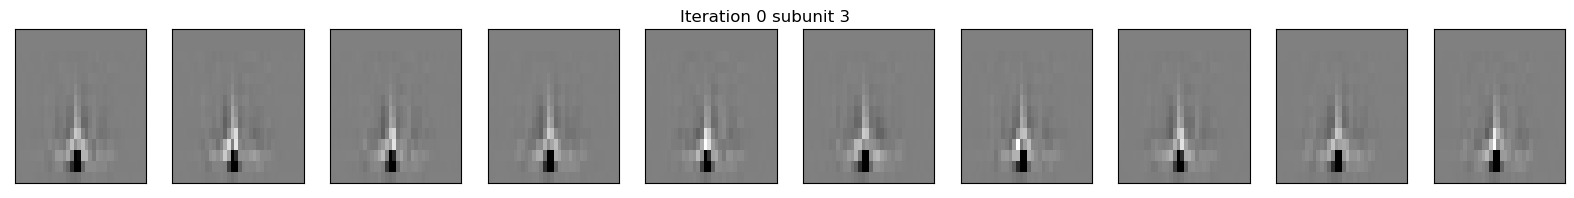

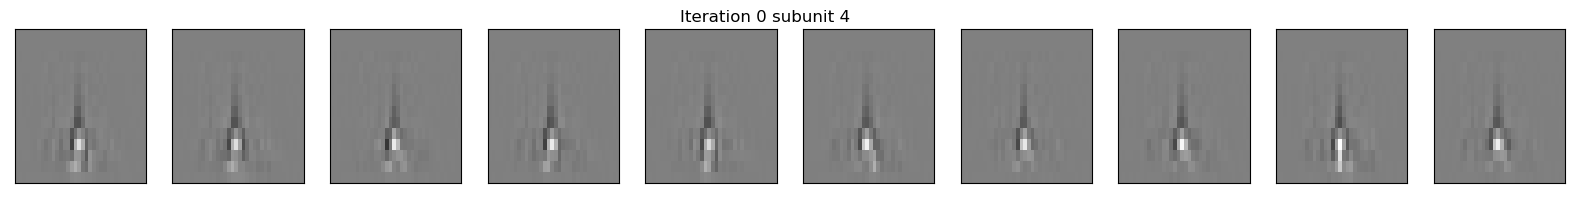

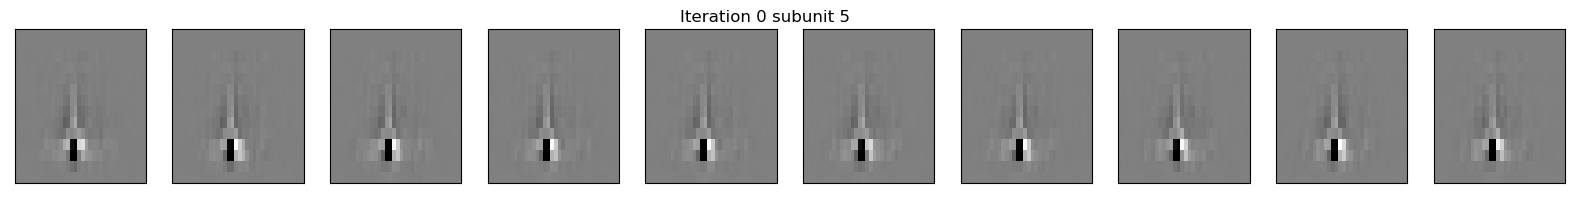

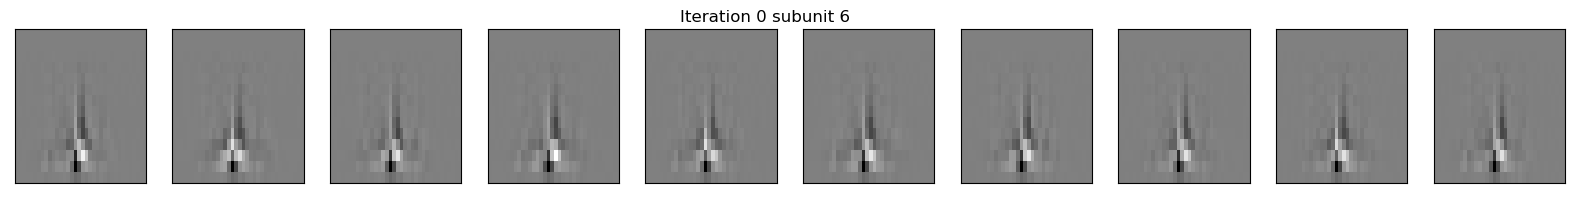

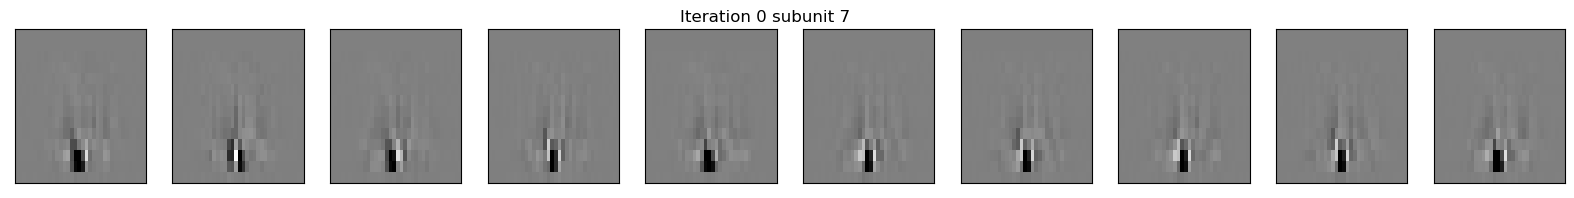

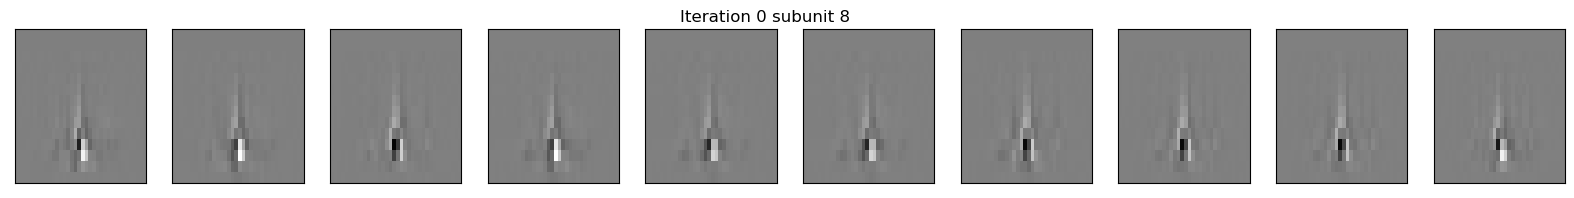

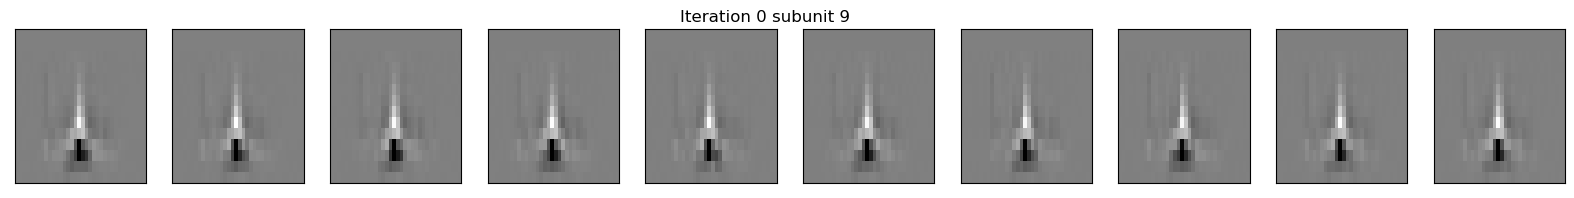

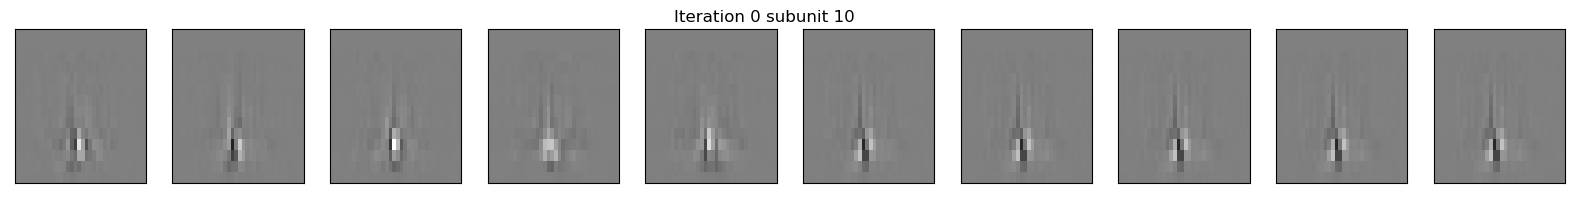

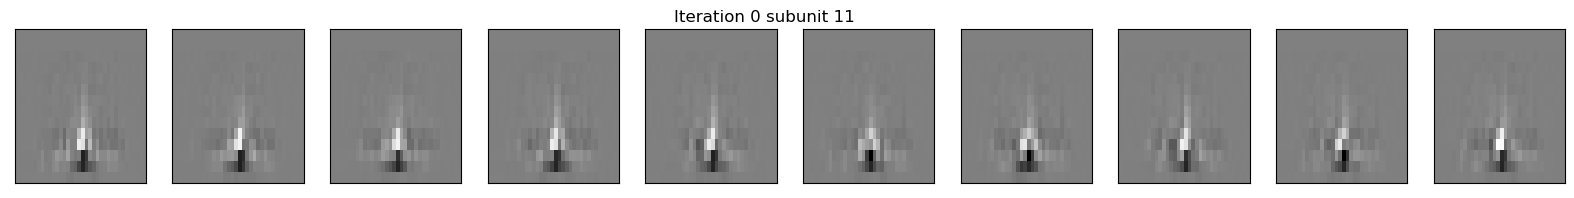

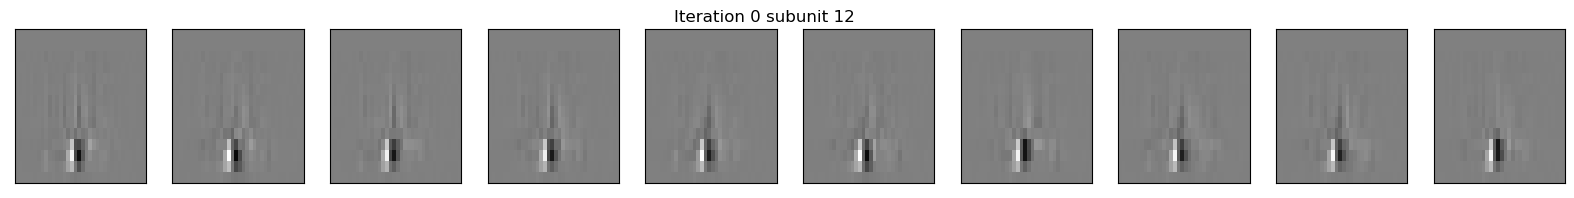

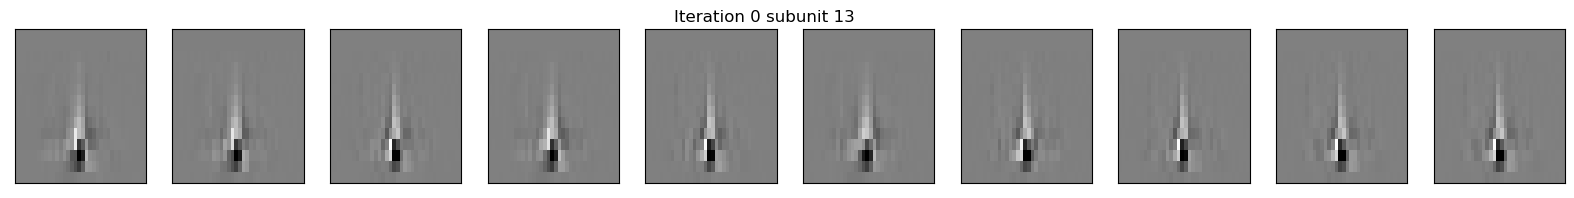

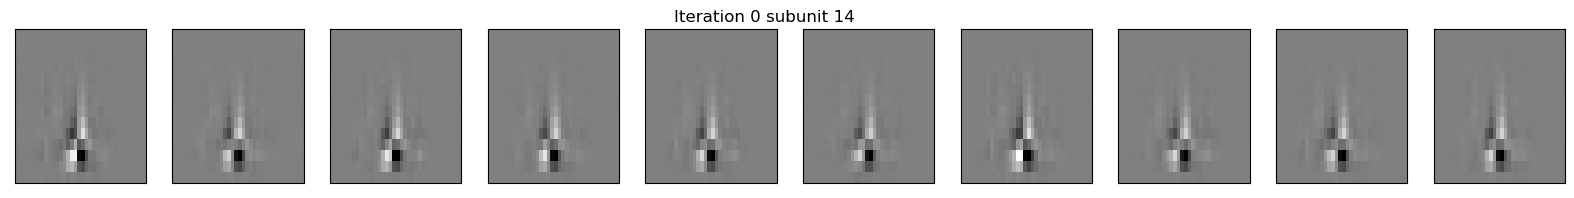

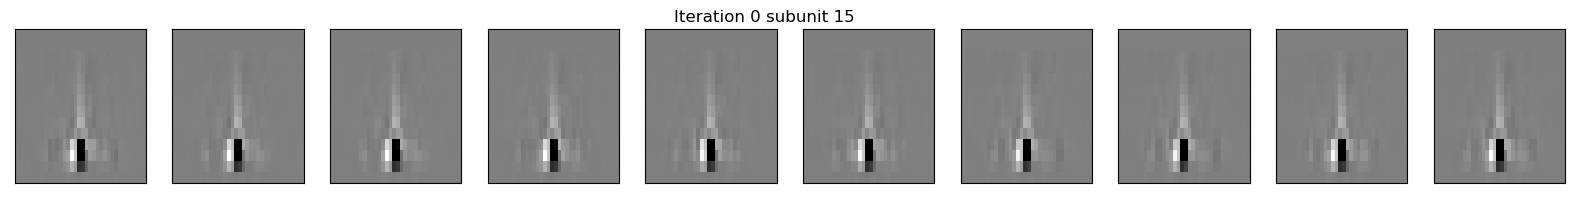

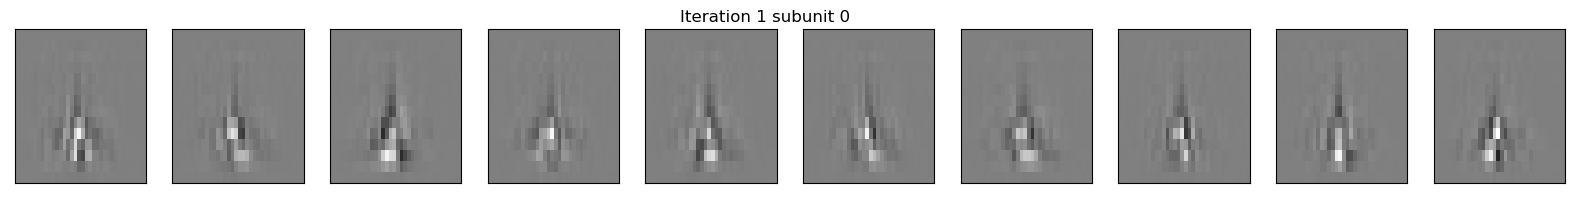

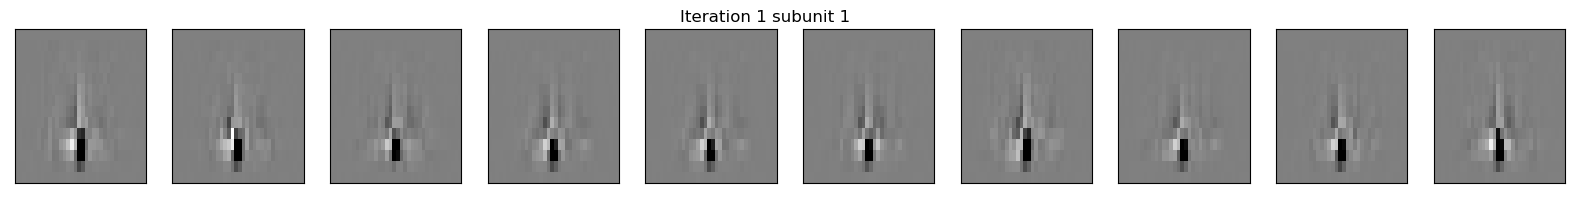

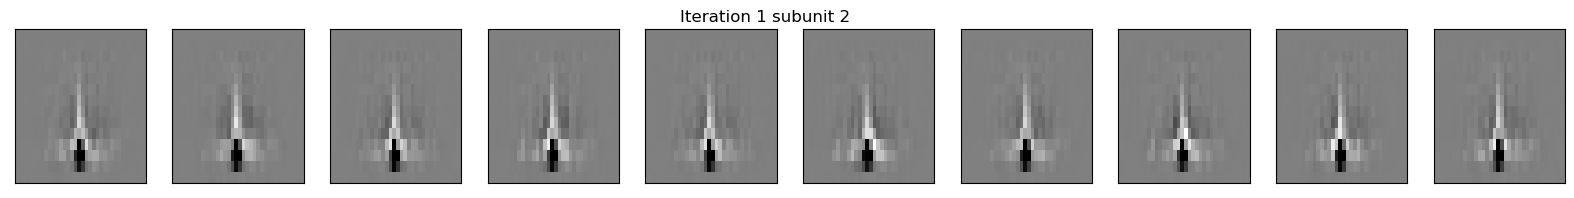

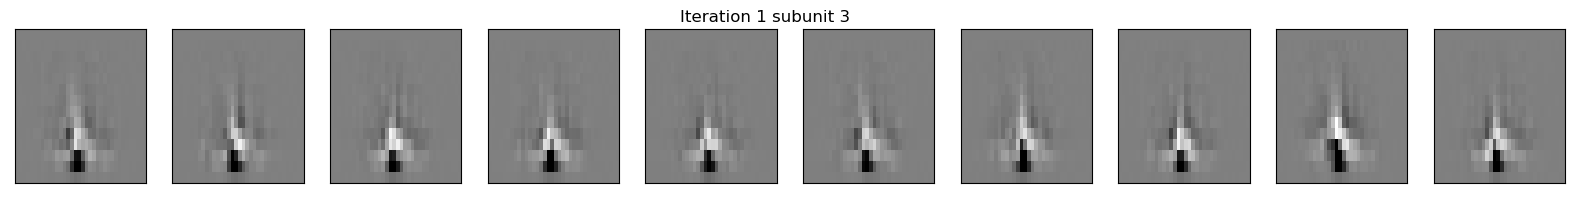

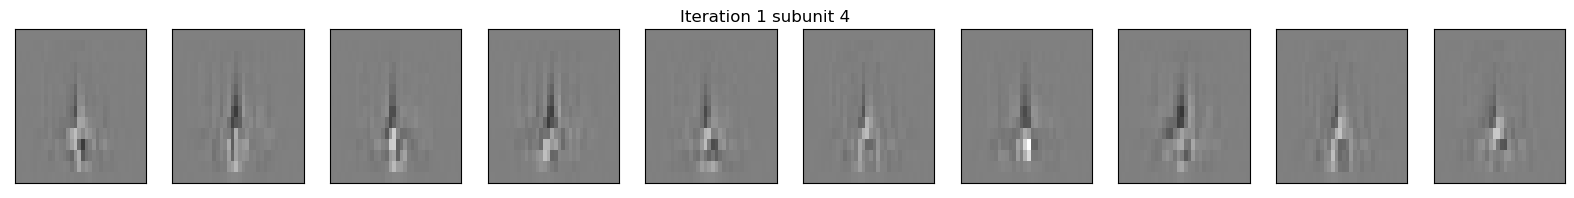

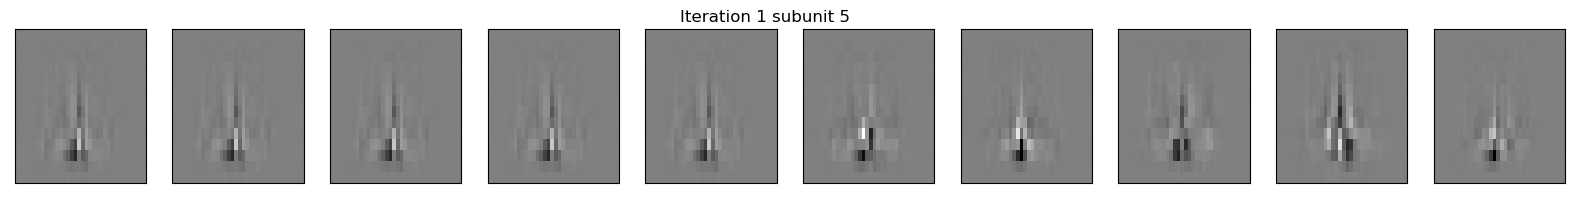

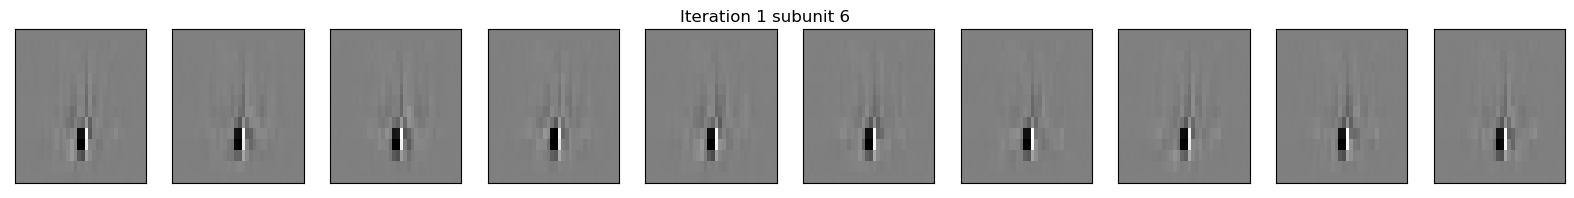

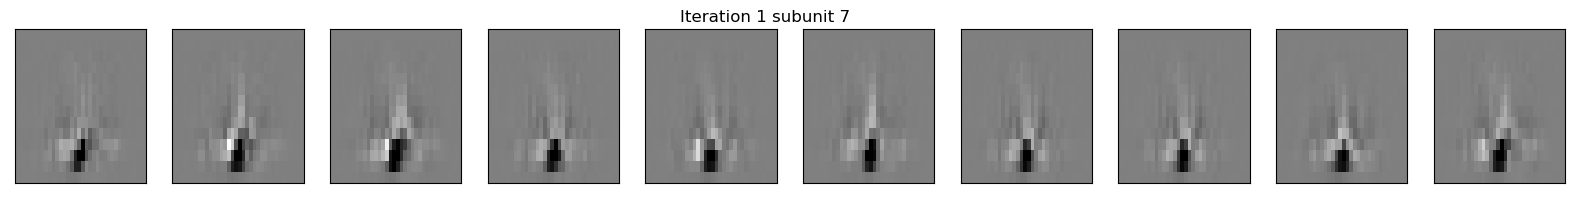

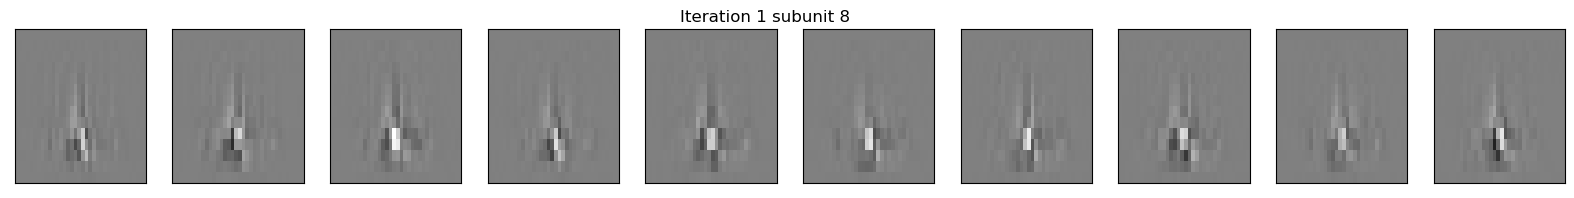

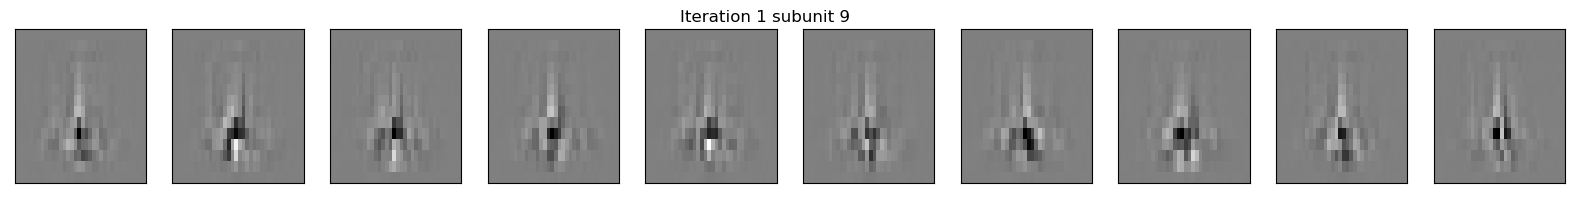

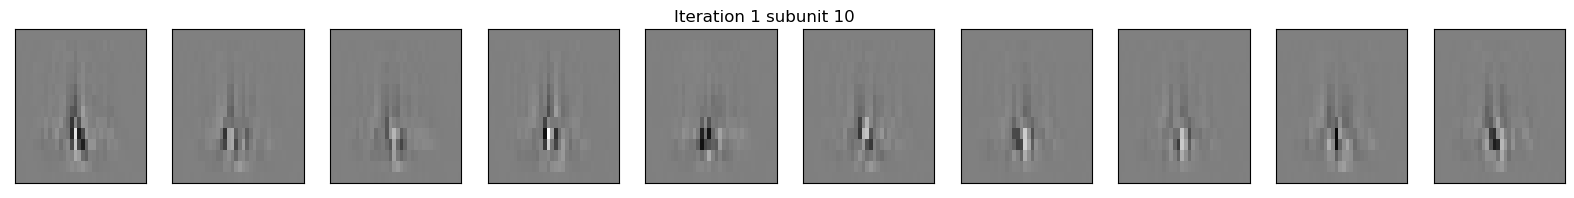

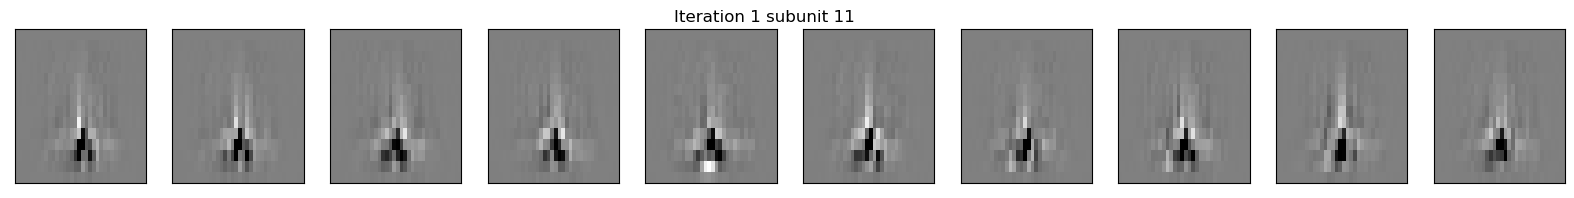

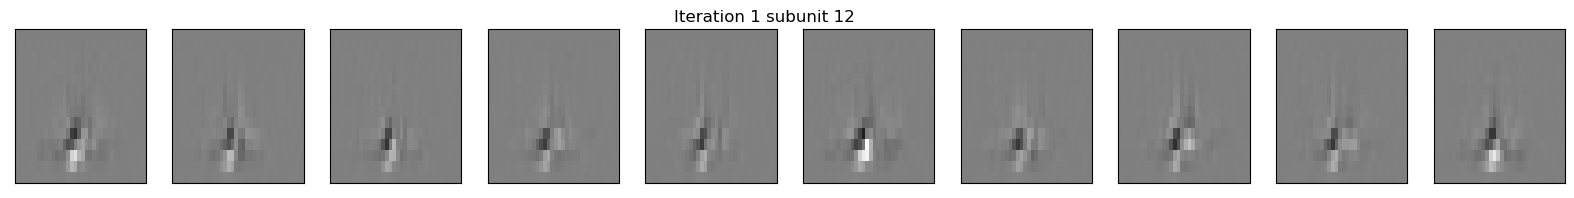

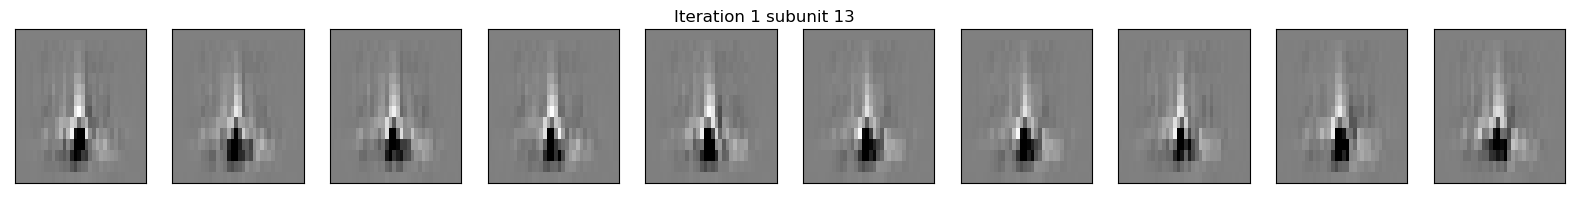

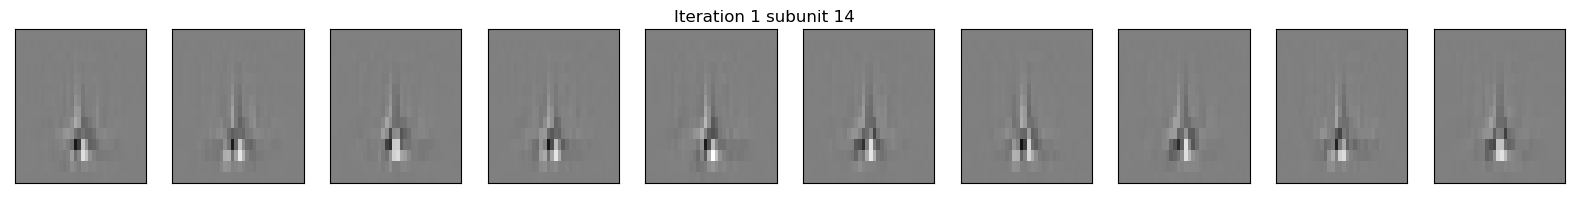

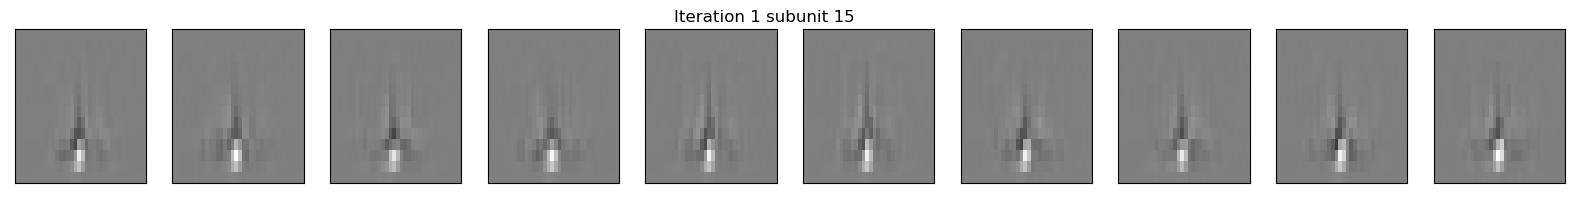

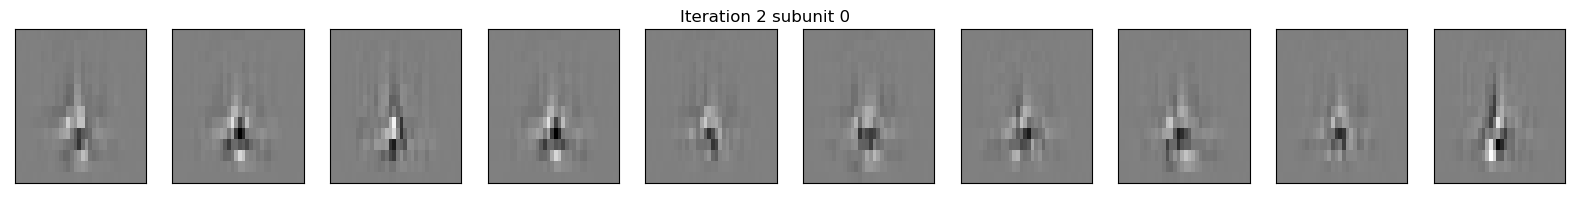

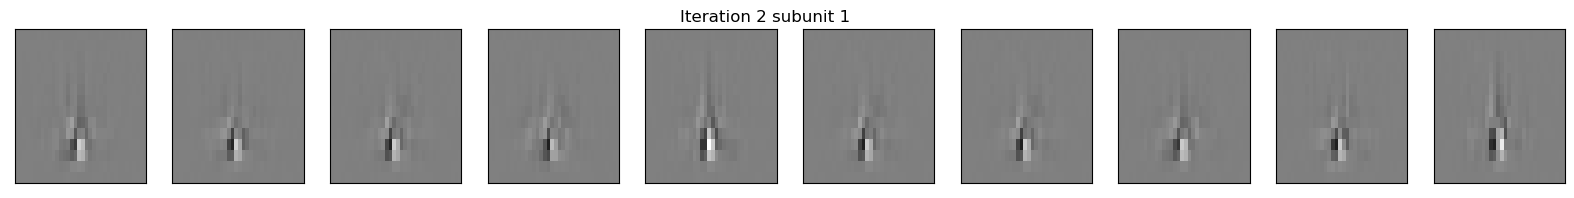

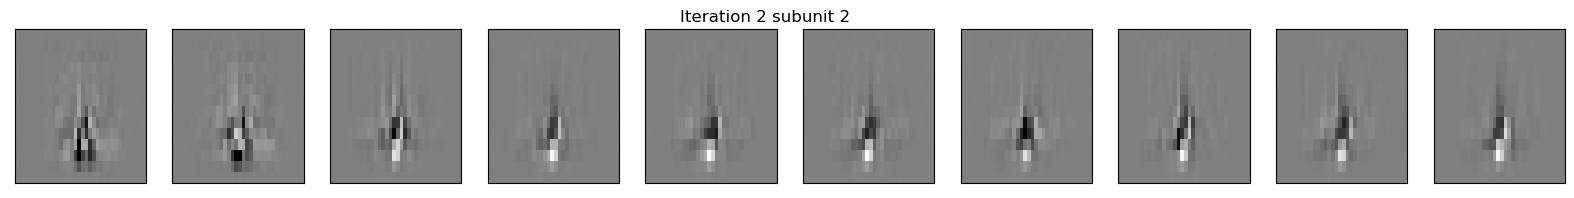

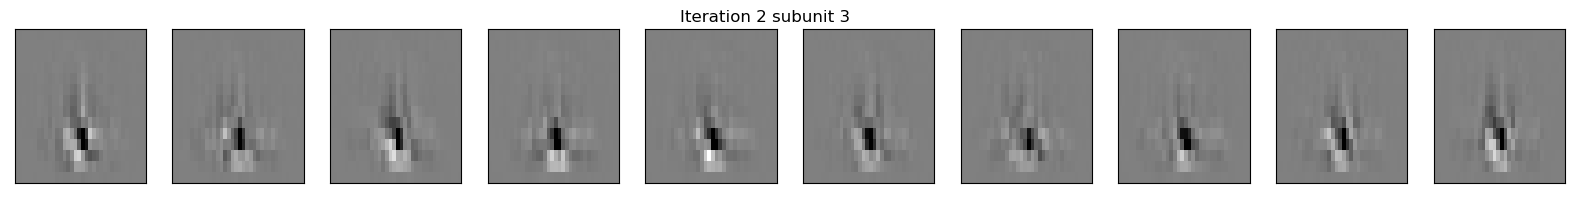

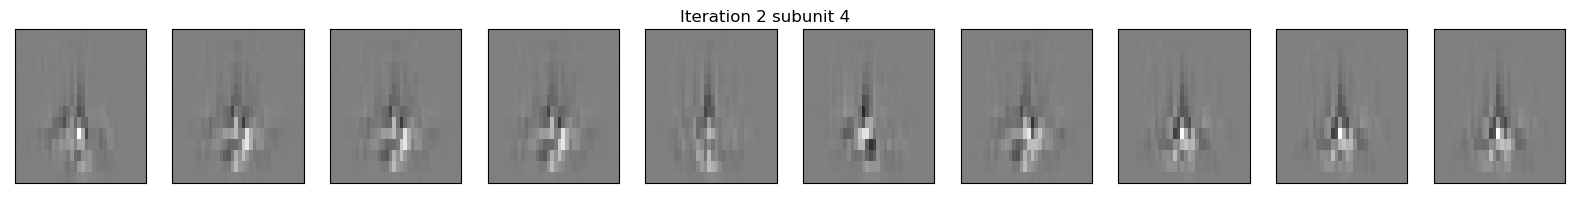

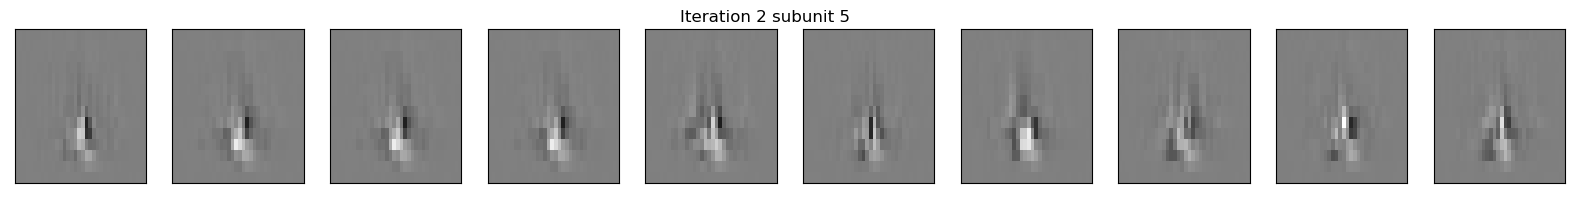

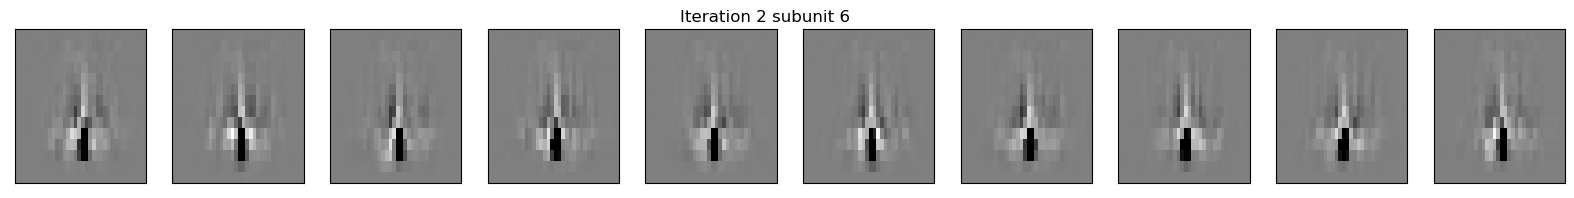

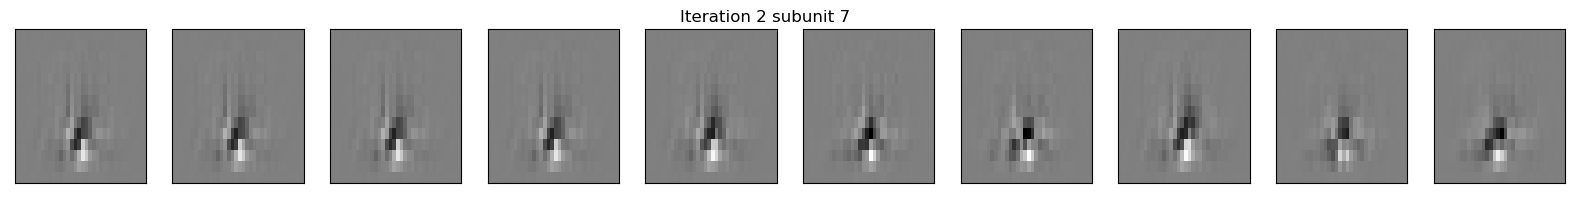

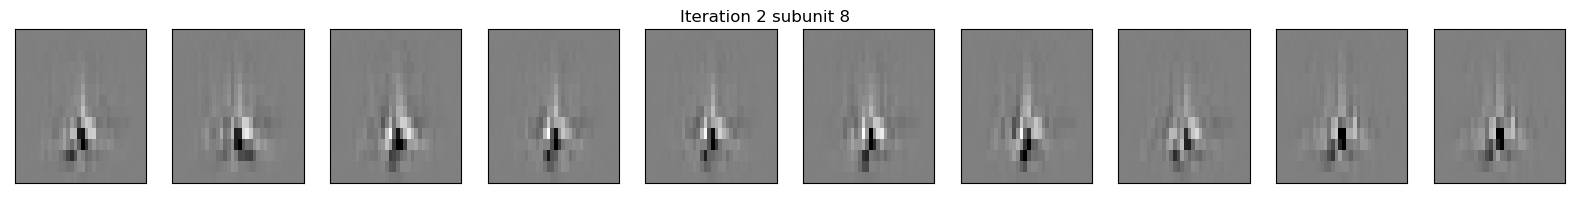

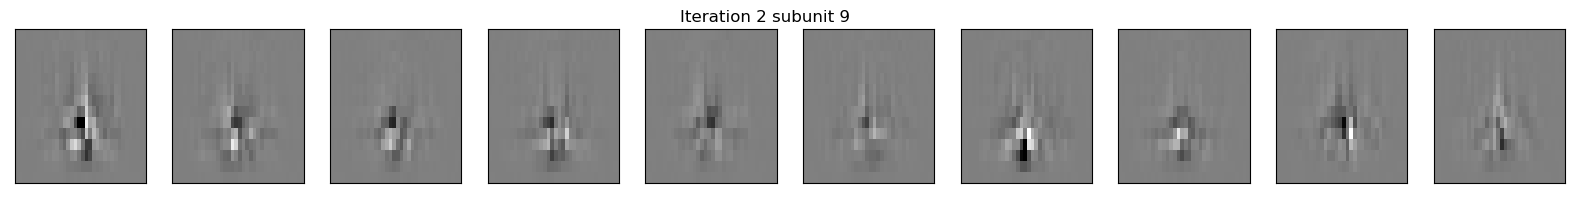

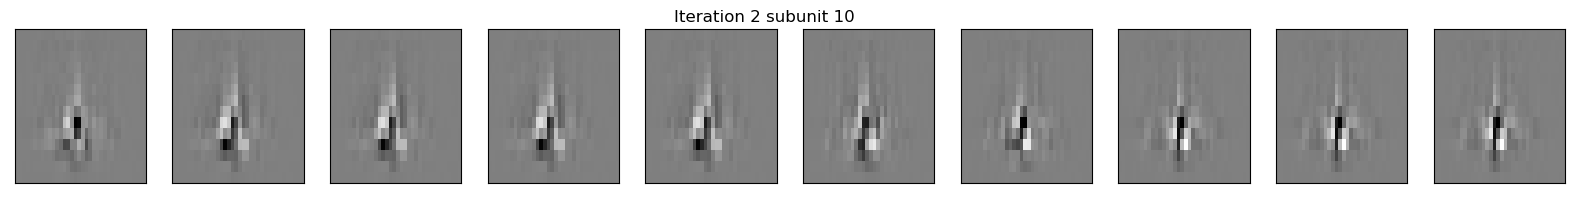

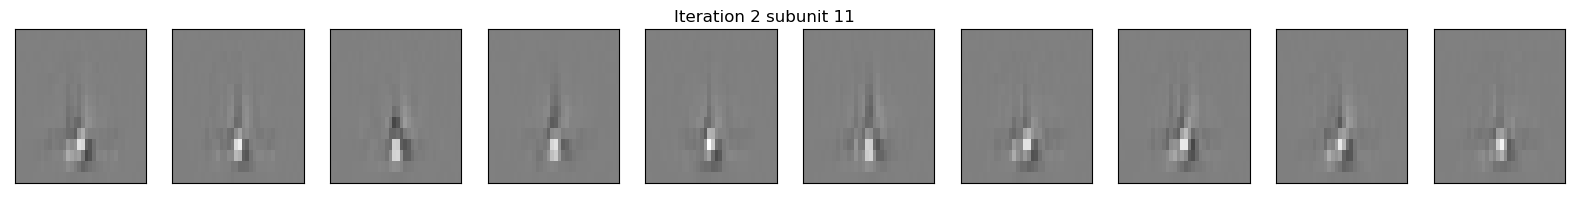

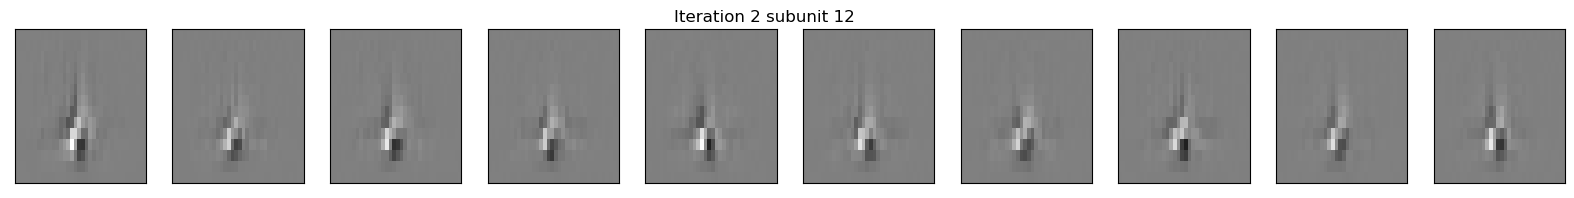

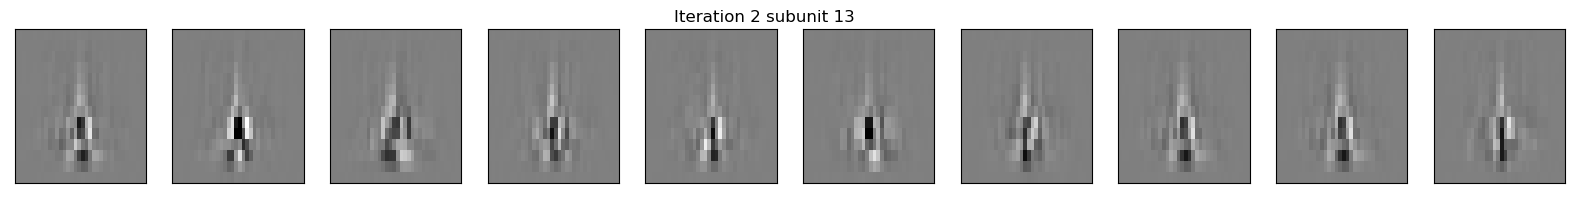

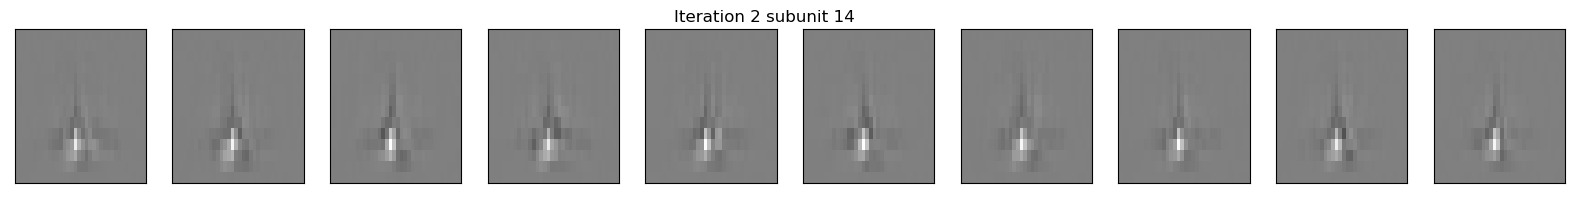

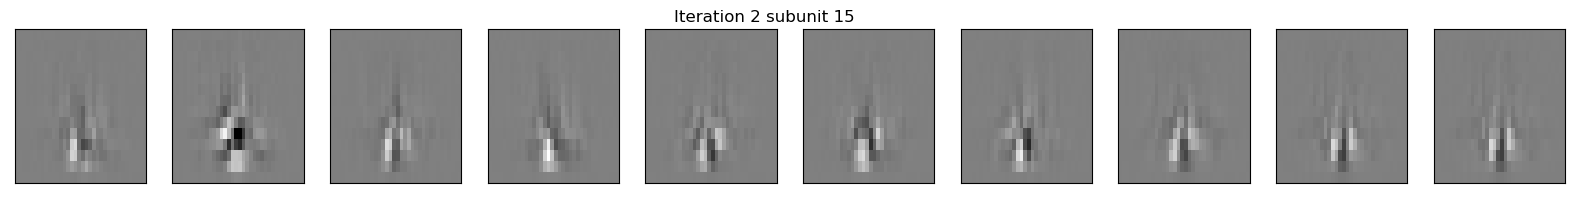

In [11]:
e.trials[0].model.NDN.plot_filters()

i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
        #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
        #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
        #    continue # skip if already done
        if li < 2:
            for subunit in range(results_outputs.outputs[ni][li].shape[1]):
                fig = plt.figure(figsize=(20,2))
                grid = matplotlib.gridspec.GridSpec(1,10)
                # plot the results jacobian
                imax = np.max(results_jacobians[i].jacobian.jacobians[0][0][:,subunit,17,0])
                imin = -imax
                for time in range(10):
                    ax = fig.add_subplot(grid[time])
                    im = results_jacobians[i].jacobian.jacobians[0][0][time,subunit,17,0].reshape(36,14).T
                    ax.imshow(im, aspect='auto', cmap='gray', origin='lower', vmin=imin, vmax=imax)
                    ax.set_xticks([])
                    ax.set_yticks([])
                if li == 0:
                    name = 'LGN'
                elif li == 1:
                    name = 'Proj'
                plt.suptitle(name+' subunit %d' % subunit)
                i += 1
                plt.show()
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                for subunit in range(results_outputs.outputs[ni][li].shape[2]):
                    fig = plt.figure(figsize=(20,2))
                    grid = matplotlib.gridspec.GridSpec(1,10)
                    imax = np.max(results_jacobians[i].jacobian.jacobians[0][0][:,iter,subunit,17,0])
                    imin = -imax
                    for time in range(10):
                        ax = fig.add_subplot(grid[time])
                        im = results_jacobians[i].jacobian.jacobians[0][0][time,iter,subunit,17,0].reshape(36,14).T
                        ax.imshow(im, aspect='auto', cmap='gray', origin='lower', vmin=imin, vmax=imax)
                        ax.set_xticks([])
                        ax.set_yticks([])
                    plt.suptitle('Iteration %d subunit %d' % (iter, subunit))
                    i += 1
                    plt.show()

In [ ]:
# # this is the time dimension
# 
# # plot some of the Jacobians
# #print(results_jacobian.xs[95])
# #print(results_jacobian.times[95])
# 
# for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
#         for li in range(len(results_outputs.outputs[ni])):
#             for lag in range(results_outputs.outputs[ni][li].shape[1]):
#                 for subunit in range(results_outputs.outputs[ni][li].shape[2]):
#                     fname = 'results_iter_exps12_3iters_jacobians/ni%d_li%d_lag%d_subunit%d_jacobians.pkl' % (ni, li, lag, subunit)
#                     with open(fname, 'rb') as f:
#                         results_jacobian = pickle.load(f)
#                         
#                     print(fname)
#                     
#                     # plot the 100 DSTRFs for this subunit at this lag
#                     fig = plt.figure(figsize=(20,10))
#                     for ti in range(100):
#                         ax = fig.add_subplot(10,10,ti+1)
#                         ax.imshow(results_jacobian.jacobian.jacobians[0][0][ti][lag][subunit][results_jacobian.xs[ti]].reshape(36,14).T,
#                                   aspect='auto', cmap='gray', origin='lower')
#                         ax.set_xticks([])
#                         ax.set_yticks([])
#                     plt.suptitle('Network %d Layer %d Lag %d Subunit %d' % (ni, li, lag, subunit))
#                     # shift the subplots up a bit
#                     plt.subplots_adjust(top=0.95)
#                     
#                     # save the figure
#                     plt.savefig('results_iter_exps12_3iters_jacobians/ni%d_li%d_lag%d_subunit%d_jacobians.png' % (ni, li, lag, subunit))

# average subunit outputs

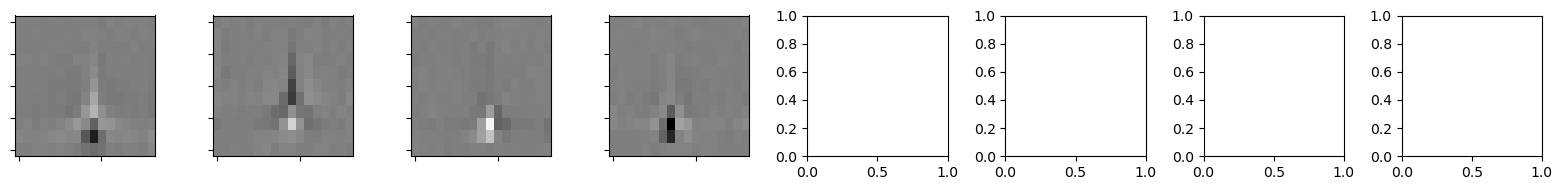

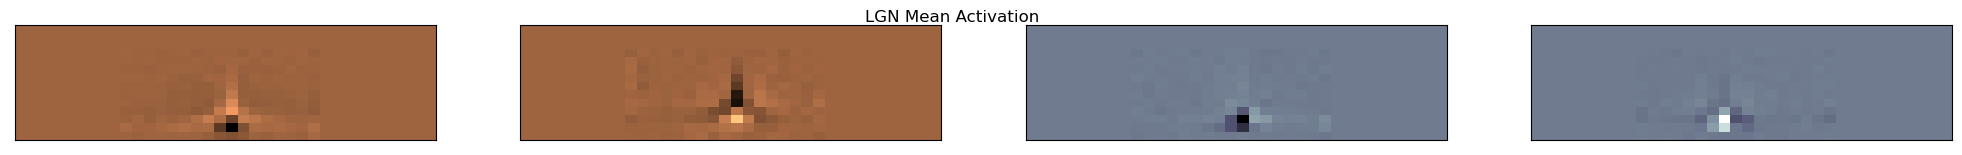

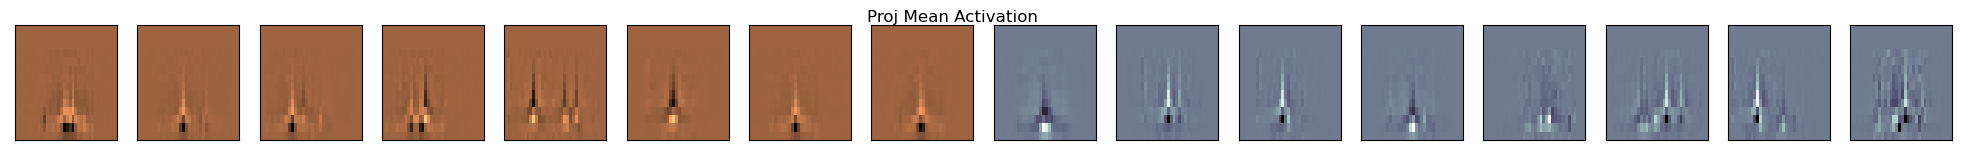

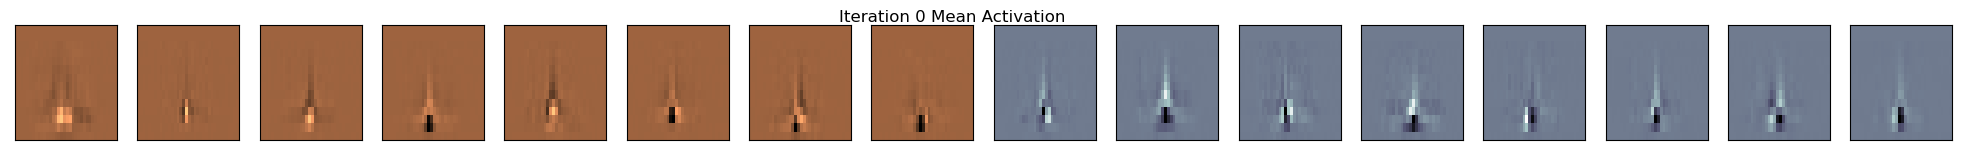

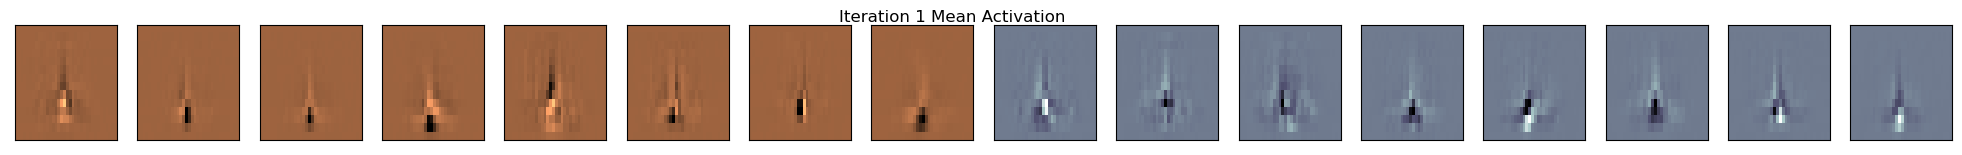

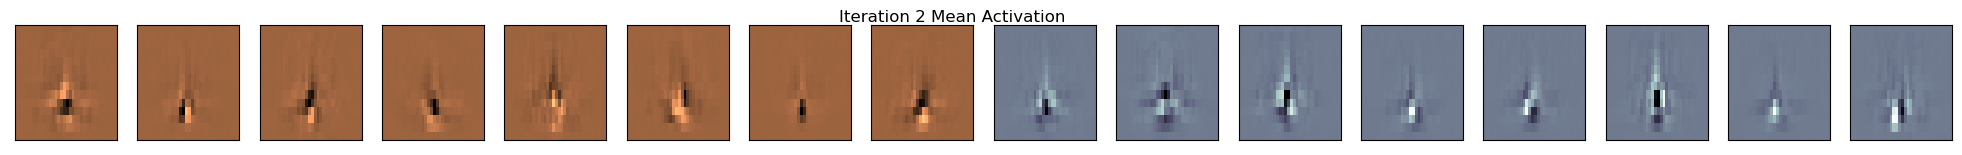

In [27]:
e.trials[0].model.NDN.plot_filters()

i = 0
for ni in range(len(results_outputs.outputs)-1): # skip the 'readout' layer
    for li in range(len(results_outputs.outputs[ni])):
        #fname = 'ni%d_li%d_subunit%d_jacobians.pkl' % (ni, li, subunit)
        #if os.path.exists('./results_iter_exps12_3iters_jacobians/'+fname):
        #    print('##### Network %d Layer %d Lag %d Subunit %d already done #####' % (ni, li, lag, subunit))
        #    continue # skip if already done
        if li < 2:
            num_subunits = results_outputs.outputs[ni][li].shape[1]
            fig = plt.figure(figsize=(25,1.5))
            grid = matplotlib.gridspec.GridSpec(1,num_subunits)
            # plot the results jacobian
            imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,:,17,0] for k in range(i,i+num_subunits)]))
            imin = -imax
            for subunit in range(num_subunits):
                if subunit >= num_subunits//2: # inhibitory subunits
                    cmap = 'bone'
                else:
                    cmap = 'copper'
                ax = fig.add_subplot(grid[subunit])
                im = np.mean(results_jacobians[i].jacobian.jacobians[0][0][:,subunit,17,0],axis=0).reshape(36,14).T
                #im = results_jacobians[i].jacobian.jacobians[0][0][0,subunit,17,0].reshape(36,14).T
                #ax.imshow(im, aspect='auto', cmap=cmap, origin='lower', vmin=imin, vmax=imax, interpolation='none')
                plot.imagesc(im.T, cmap=cmap, ax=ax)
                ax.set_xticks([])
                ax.set_yticks([])
                i += 1
            if li == 0:
                name = 'LGN Mean Activation'
            elif li == 1:
                name = 'Proj Mean Activation'
            plt.suptitle(name)
            plt.show()
        else:
            for iter in range(results_outputs.outputs[ni][li].shape[1]):
                num_subunits = results_outputs.outputs[ni][li].shape[2]
                fig = plt.figure(figsize=(25,1.5))
                grid = matplotlib.gridspec.GridSpec(1,num_subunits)
                # plot the results jacobian
                imax = np.max(np.vstack([results_jacobians[k].jacobian.jacobians[0][0][:,iter,:,17,0] for k in range(i,i+num_subunits)]))
                imin = -imax
                for subunit in range(num_subunits):
                    if subunit >= num_subunits//2: # inhibitory subunits
                        cmap = 'bone'
                    else:
                        cmap = 'copper'
                    ax = fig.add_subplot(grid[subunit])
                    im = np.mean(results_jacobians[i].jacobian.jacobians[0][0][:,iter,subunit,17,0], axis=0).reshape(36,14).T
                    #im = results_jacobians[i].jacobian.jacobians[0][0][0,iter,subunit,17,0].reshape(36,14).T
                    plot.imagesc(im.T, cmap=cmap, ax=ax)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    i += 1
                plt.suptitle('Iteration %d Mean Activation' % iter)
                plt.show()